# Home Credit - Exploratory Data Analysis


In the last Data Wrangling notebook, we explored Home Credit's internal datasets along with Credit Bureau datasets for completeness, validation and reasonableness. We also analyzed their relationship and  finally combined all the data into one as 'combined.csv'.  
In this notebook, we will

1. __resize the data__ without loss of information so that it consumes less memory.
2. __split the data__ in train and test sets.
3. quickly look at __completeness__ of data.
4. further explore the __distribution of features and their relationship with target variable__. This will a give  idea about what features can be used for prediction.  
5. understand the __relationship between features__.
6. eliminate highly missing and correlated features.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import missingno as msno

from scipy import stats
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb

%matplotlib inline
%precision %.2f

plt.style.use('bmh')
pd.set_option('display.max_rows', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 100)

In [2]:
combined = pd.read_csv('../data/interim/combined.csv',index_col='index')
combined = combined.drop('Unnamed: 0',axis =1)

In [3]:
combined.shape

(307499, 229)

In [4]:
combined.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,cr_sum_cnt_drawings_curr_mean,in_cnt_payment_sum,in_cnt_payment_mean,in_sum_payment_delay_mean,in_sum_payment_delay_max,in_sum_payment_delay_last,in_sum_payment_advance_mean,in_sum_payment_advance_max,in_sum_payment_advance_last,nflag_insured_on_approval_sum,nflag_last_appl_per_contract_sum,nflag_last_appl_in_day_sum,pc_latest_contract_status_last,cr_latest_contract_status_last,name_client_type_last,name_yield_group_grp_mode,name_yield_group_last,name_payment_type_grp_mode,name_payment_type_last,product_combination_last,name_type_suite_last,channel_type_grp_mode,channel_type_last,code_reject_reason_grp_mode,code_reject_reason_last,prev_cnt_ct_cash_loans,prev_cnt_ct_consumer_loans,prev_cnt_ct_revolving_loans,prev_cnt_cs_approved,prev_cnt_cs_canceled,prev_cnt_cs_refused,prev_cnt_cs_unused_offer,prev_cnt_pt_xna,prev_cnt_pt_walk-in,prev_cnt_pt_x-sell,bc_cnt_loans,bc_cnt_credit_type,bc_sum_cnt_credit_prolong,bc_last_days,bc_amt_max_credit_overdue,bb_last_loan_status,bb_cnt_unique_loan_obs,bc_cnt_car_loan,bc_cnt_consumer_credit,bc_cnt_cr_type_others,bc_cnt_credit_card,bc_cnt_mortgage,bc_cnt_active,bc_cnt_closed,bc_cnt_cr_status_others
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,NaN,19.0,19.000000,0.0,0.0,0.0,388.000000,388.0,388.0,0.0,1.0,1.0,Active,NaN,New,low_normal,low_normal,XNA,XNA,POS other with interest,NaN,Stone,Stone,XAP,XAP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,2.0,0.0,-7.0,5043.645,C,8.0,0.0,4.0,0.0,4.0,0.0,2.0,6.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,NaN,25.0,8.333333,0.0,0.0,0.0,59.666667,81.0,31.0,2.0,3.0,3.0,Completed,NaN,Repeater,middle,low_normal,Cash through the bank,XNA,Cash X-Sell: low,Unaccompanied,Credit and cash offices,Credit and cash offices,XAP,XAP,1.0,2.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,2.0,0.0,-43.0,0.000,NaN,0.0,0.0,2.0,0.0,2.0,0.0,1.0,3.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,3.000000,0.0,0.0,0.0,23.000000,23.0,23.0,0.0,1.0,1.0,Completed,NaN,New,middle,middle,Cash through the bank,Cash through the bank,POS mobile without interest,Unaccompanied,Regional / Local,Regional / Local,XAP,XAP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,-382.0,0.000,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
3,100006,0,Cash 

In [5]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Columns: 229 entries, sk_id_curr to bc_cnt_cr_status_others
dtypes: float64(159), int64(40), object(30)
memory usage: 539.6+ MB


combined dataframe is consuming a lot of system memory. Let us __optimize memory__ usage by changing data types without losing any information.

In [6]:
col_names = combined.columns
data_type = combined.dtypes
data_type.value_counts()

float64    159
int64       40
object      30
dtype: int64

We have 159 float64 features. We will limit these features to float16 wherever possible.

In [7]:
float_features = data_type[data_type == 'float64'].index
combined[float_features].head()

,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_employed,days_registration,own_car_age,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,...,rt_annuity_credit_max,rt_annuity_credit_last,rt_payment_delay_mean,rt_payment_delay_max,rt_payment_delay_last,rt_payment_advance_mean,rt_payment_advance_max,rt_payment_advance_last,rate_down_payment_mean,rate_down_payment_max,rate_down_payment_last,cnt_payment_sum,cnt_payment_mean,cr_sum_cnt_drawings_curr_sum,cr_sum_cnt_drawings_curr_mean,in_cnt_payment_sum,in_cnt_payment_mean,in_sum_payment_delay_mean,in_sum_payment_delay_max,in_sum_payment_delay_last,in_sum_payment_advance_mean,in_sum_payment_advance_max,in_sum_payment_advance_last,nflag_insured_on_approval_sum,nflag_last_appl_per_contract_sum,nflag_last_appl_in_day_sum,prev_cnt_ct_cash_loans,prev_cnt_ct_consumer_loans,prev_cnt_ct_revolving_loans,prev_cnt_cs_approved,prev_cnt_cs_canceled,prev_cnt_cs_refused,prev_cnt_cs_unused_offer,prev_cnt_pt_xna,prev_cnt_pt_walk-in,prev_cnt_pt_x-sell,bc_cnt_loans,bc_cnt_credit_type,bc_sum_cnt_credit_prolong,bc_last_days,bc_amt_max_credit_overdue,bb_cnt_unique_loan_obs,bc_cnt_car_loan,bc_cnt_consumer_credit,bc_cnt_cr_type_others,bc_cnt_credit_card,bc_cnt_mortgage,bc_cnt_active,bc_cnt_closed,bc_cnt_cr_status_others
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,202500.0,406597.5,24700.5,351000.0,0.018801,-637.0,-3648.0,NaN,1.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,...,0.051670,0.051670,0.000000,0.000000,0.0,0.562319,0.562319,0.562319,0.000000,0.000000,0.000000,24.0,24.000000,0.0,NaN,19.0,19.000000,0.0,0.0,0.0,388.000000,388.0,388.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,2.0,0.0,-7.0,5043.645,8.0,0.0,4.0,0.0,4.0,0.0,2.0,6.0,0.0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1188.0,-1186.0,NaN,2.0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,...,0.185200,0.094950,0.000000,0.000000,0.0,0.262020,0.446667,0.093939,0.050030,0.100061,0.000000,30.0,10.000000,0.0,NaN,25.0,8.333333,0.0,0.0,0.0,59.666667,81.0,31.0,2.0,3.0,3.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,2.0,0.0,-43.0,0.000,0.0,0.0,2.0,0.0,2.0,0.0,1.0,3.0,0.0
2,67500.0,135000.0,6750.0,135000.0,0.010032,-225.0,-4260.0,26.0,1.0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.266450,0.266450,0.000000,0.000000,0.0,0.255556,0.255556,0.255556,0.212008,0.212008,0.212008,4.0,4.000000,0.0,NaN,3.0,3.000000,0.0,0.0,0.0,23.000000,23.0,23.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,-382.0,0.000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-3039.0,-9833.0,NaN,2.0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Range for float16 datatype

In [8]:
f16_min = np.finfo(np.float16).min
f16_max = np.finfo(np.float16).max
f16_min,f16_max

(-65500.0, 65500.0)

Getting minimum and maximum values of each features.

In [9]:
df_float = pd.DataFrame()
df_float['ft_min'] = combined[float_features].min()
df_float['ft_max'] = combined[float_features].max()
df_float.head()

,ft_min,ft_max
amt_income_total,25650.00000,1.170000e+08
amt_credit,45000.00000,4.050000e+06
amt_annuity,1615.50000,2.580255e+05
amt_goods_price,40500.00000,4.050000e+06
region_population_relative,0.00029,7.250800e-02


Identifying features which are within float16 range to be converted to float16

In [10]:
small_float_col = df_float[((df_float.ft_min > f16_min) & (df_float.ft_max <  f16_max))].index
combined[small_float_col] = combined[small_float_col].astype(np.float16)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Columns: 229 entries, sk_id_curr to bc_cnt_cr_status_others
dtypes: float16(136), float64(23), int64(40), object(30)
memory usage: 300.3+ MB


With float64 to float16 conversion, we have successfully __reduced the memory size by 40%.__

Similarly, we can convert int64 datatype to int8.

In [11]:
int_features = data_type[data_type == 'int64'].index
combined[int_features].head()

,sk_id_curr,target,cnt_children,days_birth,days_id_publish,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,region_rating_client,region_rating_client_w_city,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,100002,1,0,-9461,-2120,1,1,0,1,1,0,2,2,10,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,-16765,-291,1,1,0,1,1,0,1,1,11,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,0,-19046,-2531,1,1,1,1,1,0,2,2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,-19005,-2437,1,1,0,1,0,0,2,2,17,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,-19932,-3458,1,1,0,1,0,0,2,2,11,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


A quick look at data suggests that all features except sk_id_curr,days_birth,days_employed and days_id_publish features can have positive values but less than 255. Performing a check below on rest of the features.

In [12]:
big_int_col = ['sk_id_curr','days_birth','days_employed','days_id_publish']
small_int_col = list(set(int_features) - set(big_int_col))
# Getting minimum & maximum values of from all features.
combined[small_int_col].min().min(),combined[small_int_col].max().max()

(0, 23)

Converting them to int8 type.

In [13]:
combined[small_int_col] = combined[small_int_col].astype(np.int8)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307499 entries, 0 to 307510
Columns: 229 entries, sk_id_curr to bc_cnt_cr_status_others
dtypes: float16(136), float64(23), int64(3), int8(37), object(30)
memory usage: 224.3+ MB


Finally, we have reduced the __memory size by more than 50%.__

In [14]:
# Check whether all columns are present.
list(set(combined.columns) - set(col_names))

[]

In [15]:
combined.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,cr_sum_cnt_drawings_curr_mean,in_cnt_payment_sum,in_cnt_payment_mean,in_sum_payment_delay_mean,in_sum_payment_delay_max,in_sum_payment_delay_last,in_sum_payment_advance_mean,in_sum_payment_advance_max,in_sum_payment_advance_last,nflag_insured_on_approval_sum,nflag_last_appl_per_contract_sum,nflag_last_appl_in_day_sum,pc_latest_contract_status_last,cr_latest_contract_status_last,name_client_type_last,name_yield_group_grp_mode,name_yield_group_last,name_payment_type_grp_mode,name_payment_type_last,product_combination_last,name_type_suite_last,channel_type_grp_mode,channel_type_last,code_reject_reason_grp_mode,code_reject_reason_last,prev_cnt_ct_cash_loans,prev_cnt_ct_consumer_loans,prev_cnt_ct_revolving_loans,prev_cnt_cs_approved,prev_cnt_cs_canceled,prev_cnt_cs_refused,prev_cnt_cs_unused_offer,prev_cnt_pt_xna,prev_cnt_pt_walk-in,prev_cnt_pt_x-sell,bc_cnt_loans,bc_cnt_credit_type,bc_sum_cnt_credit_prolong,bc_last_days,bc_amt_max_credit_overdue,bb_last_loan_status,bb_cnt_unique_loan_obs,bc_cnt_car_loan,bc_cnt_consumer_credit,bc_cnt_cr_type_others,bc_cnt_credit_card,bc_cnt_mortgage,bc_cnt_active,bc_cnt_closed,bc_cnt_cr_status_others
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018799,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083008,0.262939,0.139404,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,...,NaN,19.0,19.000000,0.0,0.0,0.0,388.00000,388.0,388.0,0.0,1.0,1.0,Active,NaN,New,low_normal,low_normal,XNA,XNA,POS other with interest,NaN,Stone,Stone,XAP,XAP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,2.0,0.0,-7.0,5043.645,C,8.0,0.0,4.0,0.0,4.0,0.0,2.0,6.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311279,0.622070,NaN,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,...,NaN,25.0,8.335938,0.0,0.0,0.0,59.65625,81.0,31.0,2.0,3.0,3.0,Completed,NaN,Repeater,middle,low_normal,Cash through the bank,XNA,Cash X-Sell: low,Unaccompanied,Credit and cash offices,Credit and cash offices,XAP,XAP,1.0,2.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,2.0,0.0,-43.0,0.000,NaN,0.0,0.0,2.0,0.0,2.0,0.0,1.0,3.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010033,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.556152,0.729492,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,3.000000,0.0,0.0,0.0,23.00000,23.0,23.0,0.0,1.0,1.0,Completed,NaN,New,middle,middle,Cash through the bank,Cash through the bank,POS mobile without interest,Unaccompanied,Regional / Local,Regional / Local,XAP,XAP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,-382.0,0.000,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0

#### Indentifying numerical and categorical features  

In [16]:
num_features = ['cnt_children', 
                'amt_income_total',
                'amt_credit',
                'amt_annuity',
                'amt_goods_price',
                'region_population_relative',
                'days_birth',
                'days_employed',
                'days_registration',
                'days_id_publish',
                'own_car_age',
                'cnt_fam_members',
                'hour_appr_process_start',
                'ext_source_1',
                'ext_source_2',
                'ext_source_3',
                'apartments_avg',
                'basementarea_avg',
                'years_beginexpluatation_avg',
                'years_build_avg',
                'commonarea_avg',
                'elevators_avg',
                'entrances_avg',
                'floorsmax_avg',
                'floorsmin_avg',
                'landarea_avg',
                'livingapartments_avg',
                'livingarea_avg',
                'nonlivingapartments_avg',
                'nonlivingarea_avg',
                'apartments_mode',
                'basementarea_mode',
                'years_beginexpluatation_mode',
                'years_build_mode',
                'commonarea_mode',
                'elevators_mode',
                'entrances_mode',
                'floorsmax_mode',
                'floorsmin_mode',
                'landarea_mode',
                'livingapartments_mode',
                'livingarea_mode',
                'nonlivingapartments_mode',
                'nonlivingarea_mode',
                'apartments_medi',
                'basementarea_medi',
                'years_beginexpluatation_medi',
                'years_build_medi',
                'commonarea_medi',
                'elevators_medi',
                'entrances_medi',
                'floorsmax_medi',
                'floorsmin_medi',
                'landarea_medi',
                'livingapartments_medi',
                'livingarea_medi',
                'nonlivingapartments_medi',
                'nonlivingarea_medi',
                'totalarea_mode',
                'obs_30_cnt_social_circle',
                'def_30_cnt_social_circle',
                'obs_60_cnt_social_circle',
                'def_60_cnt_social_circle',
                'days_last_phone_change',
                'amt_req_credit_bureau_hour',
                'amt_req_credit_bureau_day',
                'amt_req_credit_bureau_week',
                'amt_req_credit_bureau_mon',
                'amt_req_credit_bureau_qrt',
                'amt_req_credit_bureau_year',
                'amt_annuity_mean',
                'amt_annuity_max',
                'amt_annuity_last',
                'amt_credit_mean',
                'amt_credit_max',
                'amt_credit_last',
                'amt_down_payment_mean',
                'amt_down_payment_max',
                'amt_down_payment_last',
                'amt_goods_price_mean',
                'amt_goods_price_max',
                'cr_max_amt_cr_limit_max',
                'cr_max_amt_cr_limit_last',
                'cr_max_amt_balance_max',
                'cr_max_amt_payment_tot_max',
                'pc_max_sk_dpd_max',
                'pc_max_sk_dpd_last',
                'pc_max_sk_dpd_def_max',
                'pc_max_sk_dpd_def_last',
                'cr_max_sk_dpd_max',
                'cr_max_sk_dpd_last',
                'cr_max_sk_dpd_def_max',
                'cr_max_sk_dpd_def_last',
                'loan_durtn_1st_ver_sum',
                'loan_durtn_1st_ver_mean',
                'days_decision_mean',
                'days_decision_last',
                'cr_rt_max_balance_cr_max',
                'cr_rt_max_payment_inst_max',
                'in_rt_cnt_deficit_pmt_mean',
                'in_rt_cnt_deficit_pmt_max',
                'in_rt_cnt_surplus_pmt_mean',
                'in_rt_cnt_surplus_pmt_max',
                'in_rt_amt_deficit_inst_mean',
                'in_rt_amt_deficit_inst_max',
                'in_rt_amt_deficit_inst_last',
                'in_rt_amt_surplus_inst_mean',
                'in_rt_amt_surplus_inst_max',
                'in_rt_amt_surplus_inst_last',
                'rt_credit_application_mean',
                'rt_credit_application_max',
                'rt_credit_application_last',
                'rt_annuity_credit_mean',
                'rt_annuity_credit_max',
                'rt_annuity_credit_last',
                'rt_payment_delay_mean',
                'rt_payment_delay_max',
                'rt_payment_delay_last',
                'rt_payment_advance_mean',
                'rt_payment_advance_max',
                'rt_payment_advance_last',
                'rate_down_payment_mean',
                'rate_down_payment_max',
                'rate_down_payment_last',
                'cnt_payment_sum',
                'cnt_payment_mean',
                'cr_sum_cnt_drawings_curr_sum',
                'cr_sum_cnt_drawings_curr_mean',
                'in_cnt_payment_sum',
                'in_cnt_payment_mean',
                'in_sum_payment_delay_mean',
                'in_sum_payment_delay_max',
                'in_sum_payment_delay_last',
                'in_sum_payment_advance_mean',
                'in_sum_payment_advance_max',
                'in_sum_payment_advance_last',
                'nflag_insured_on_approval_sum',
                'nflag_last_appl_per_contract_sum',
                'nflag_last_appl_in_day_sum',
                'prev_cnt_ct_cash_loans',
                'prev_cnt_ct_consumer_loans',
                'prev_cnt_cs_approved',
                'prev_cnt_cs_canceled',
                'prev_cnt_cs_refused',
                'prev_cnt_cs_unused_offer',
                'prev_cnt_pt_xna',
                'prev_cnt_pt_walk-in',
                'prev_cnt_pt_x-sell',
                'bc_cnt_loans',
                'bc_cnt_credit_type',
                'bc_sum_cnt_credit_prolong',
                'bc_last_days',
                'bc_amt_max_credit_overdue',
                'bb_cnt_unique_loan_obs',
                'bc_cnt_car_loan',
                'bc_cnt_consumer_credit',
                'bc_cnt_cr_type_others',
                'bc_cnt_credit_card',
                'bc_cnt_mortgage',
                'bc_cnt_active',
                'bc_cnt_closed',
                'bc_cnt_cr_status_others']

In [17]:
cat_features = ['name_contract_type',
                'code_gender',
                'flag_own_car',
                'flag_own_realty',
                'name_type_suite',
                'name_income_type',
                'name_education_type',
                'name_family_status',
                'name_housing_type',
                'flag_mobil',
                'flag_emp_phone',
                'flag_work_phone',
                'flag_cont_mobile',
                'flag_phone',
                'flag_email',
                'occupation_type',
                'region_rating_client',
                'region_rating_client_w_city',
                'weekday_appr_process_start',
                'reg_region_not_live_region',
                'reg_region_not_work_region',
                'live_region_not_work_region',
                'reg_city_not_live_city',
                'reg_city_not_work_city',
                'live_city_not_work_city',
                'organization_type',
                'fondkapremont_mode',
                'housetype_mode',
                'wallsmaterial_mode',
                'emergencystate_mode',
                'flag_document_2',
                'flag_document_3',
                'flag_document_4',
                'flag_document_5',
                'flag_document_6',
                'flag_document_7',
                'flag_document_8',
                'flag_document_9',
                'flag_document_10',
                'flag_document_11',
                'flag_document_12',
                'flag_document_13',
                'flag_document_14',
                'flag_document_15',
                'flag_document_16',
                'flag_document_17',
                'flag_document_18',
                'flag_document_19',
                'flag_document_20',
                'flag_document_21',
                'pc_latest_contract_status_last',
                'cr_latest_contract_status_last',
                'name_client_type_last',
                'name_yield_group_grp_mode',
                'name_yield_group_last',
                'name_payment_type_grp_mode',
                'name_payment_type_last',
                'product_combination_last',
                'name_type_suite_last',
                'channel_type_grp_mode',
                'channel_type_last',
                'code_reject_reason_grp_mode',
                'code_reject_reason_last',
                'bb_last_loan_status']

### Splitting into train, test set

Using stratify, we make sure that train and test set have same default rates.

In [18]:
df_train, df_test = train_test_split(combined, test_size=0.3, stratify=combined.target, random_state= 47)

In [19]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [20]:
df_train.shape,df_test.shape

((215249, 229), (92250, 229))

In [21]:
round(df_train.target.mean(),3),round(df_test.target.mean(),3)

(0.081, 0.081)

In [22]:
df_train.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,cr_sum_cnt_drawings_curr_mean,in_cnt_payment_sum,in_cnt_payment_mean,in_sum_payment_delay_mean,in_sum_payment_delay_max,in_sum_payment_delay_last,in_sum_payment_advance_mean,in_sum_payment_advance_max,in_sum_payment_advance_last,nflag_insured_on_approval_sum,nflag_last_appl_per_contract_sum,nflag_last_appl_in_day_sum,pc_latest_contract_status_last,cr_latest_contract_status_last,name_client_type_last,name_yield_group_grp_mode,name_yield_group_last,name_payment_type_grp_mode,name_payment_type_last,product_combination_last,name_type_suite_last,channel_type_grp_mode,channel_type_last,code_reject_reason_grp_mode,code_reject_reason_last,prev_cnt_ct_cash_loans,prev_cnt_ct_consumer_loans,prev_cnt_ct_revolving_loans,prev_cnt_cs_approved,prev_cnt_cs_canceled,prev_cnt_cs_refused,prev_cnt_cs_unused_offer,prev_cnt_pt_xna,prev_cnt_pt_walk-in,prev_cnt_pt_x-sell,bc_cnt_loans,bc_cnt_credit_type,bc_sum_cnt_credit_prolong,bc_last_days,bc_amt_max_credit_overdue,bb_last_loan_status,bb_cnt_unique_loan_obs,bc_cnt_car_loan,bc_cnt_consumer_credit,bc_cnt_cr_type_others,bc_cnt_credit_card,bc_cnt_mortgage,bc_cnt_active,bc_cnt_closed,bc_cnt_cr_status_others
0,389706,0,Revolving loans,F,N,Y,2,45000.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018204,-13349,-2716.0,-3004.0,-4335,NaN,1,1,0,1,1,0,Sales staff,4.0,3,3,SATURDAY,12,0,0,0,0,0,0,Self-employed,0.581055,0.734375,0.667480,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,41.0,10.25000,2.000000,8.0,0.0,177.000,427.0,8.0,3.0,5.0,5.0,Active,NaN,Repeater,high,low_action,Cash through the bank,Cash through the bank,POS household without interest,Unaccompanied,Credit and cash offices,Country-wide,XAP,XAP,2.0,3.0,0.0,4.0,0.0,1.0,0.0,3.0,0.0,2.0,2.0,1.0,0.0,-10.0,0.0,NaN,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0
1,225912,0,Revolving loans,M,N,Y,1,103500.0,247500.0,12375.0,247500.0,Unaccompanied,Working,Secondary / secondary special,Widow,Rented apartment,0.020706,-15566,-648.0,-649.0,-4297,NaN,1,1,0,1,0,0,Laborers,2.0,3,2,WEDNESDAY,7,0,0,0,0,0,0,Industry: type 7,0.538574,0.544922,0.845215,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.0,9.00000,0.000000,0.0,0.0,234.000,234.0,234.0,0.0,1.0,1.0,Completed,NaN,New,low_normal,low_normal,Cash through the bank,Cash through the bank,POS mobile without interest,NaN,Country-wide,Country-wide,XAP,XAP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,2.0,1.0,-6.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,0.0,3.0,2.0,0.0
2,405407,0,Revolving loans,M,N,N,0,90000.0,135000.0,6750.0,135000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.025162,-14437,-352.0,-786.0,-5261,NaN,1,1,0,1,0,0,High skill tech staff,1.0,2,2,SUNDAY,9,0,0,0,0,0,0,Business Entity Type 2,NaN,0.197510,NaN,0.105225,0.059998,0.984375,0.789062,0.021103,0.080017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0.0,-1629.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0
3,172092,0,Cash loans,M,N,Y,0,121500.0,254700.0,26874.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / 

Going forward, we will use training dataset for EDA.

## Completeness

In [23]:
missing_col = pd.DataFrame(df_train.isna().mean().round(3).sort_values(ascending=False))
missing_col.columns = ['Missing %']
missing_col.loc[:,'Missing %'] = missing_col.loc[:,'Missing %']*100
missing_col.index.name = 'Feature'
missing_col.head(10)

,Missing %
Feature,
cr_rt_max_payment_inst_max,83.4
cr_rt_max_balance_cr_max,75.0
cr_max_amt_payment_tot_max,74.7
cr_max_amt_cr_limit_last,74.7
cr_latest_contract_status_last,74.7
cr_max_sk_dpd_def_last,74.7
cr_max_sk_dpd_def_max,74.7
cr_max_sk_dpd_last,74.7
cr_max_sk_dpd_max,74.7


Top columns are from credit loan features. This is as expected because only __28.2%__ of the current applicants had credit card in the past some feautures had missing values.

From last exercise, we already know that property/area realted features are having higher missing %.

In [24]:
prop_col =  ['commonarea_medi', 'commonarea_avg', 'commonarea_mode',
            'nonlivingapartments_mode', 'nonlivingapartments_avg',
            'nonlivingapartments_medi', 'fondkapremont_mode',
            'livingapartments_mode', 'livingapartments_avg',
            'livingapartments_medi', 'floorsmin_avg', 'floorsmin_mode',
            'floorsmin_medi', 'years_build_medi', 'years_build_mode',
            'years_build_avg', 'landarea_medi', 'landarea_mode',
            'landarea_avg', 'basementarea_medi', 'basementarea_avg',
            'basementarea_mode', 'nonlivingarea_mode',
            'nonlivingarea_avg', 'nonlivingarea_medi', 'elevators_medi',
            'elevators_avg', 'elevators_mode', 'wallsmaterial_mode',
            'apartments_medi', 'apartments_avg', 'apartments_mode',
            'entrances_medi', 'entrances_avg', 'entrances_mode', 'livingarea_avg',
            'livingarea_mode', 'livingarea_medi', 'housetype_mode',
            'floorsmax_mode', 'floorsmax_medi', 'floorsmax_avg',
            'years_beginexpluatation_mode', 'years_beginexpluatation_medi',
            'years_beginexpluatation_avg', 'totalarea_mode', 'emergencystate_mode']

In [25]:
print('Number of property/area features : ', len(prop_col))
print('Missing value % - Max  : {} , Min  : {}'.format(
    missing_col.loc[prop_col,].max().values,missing_col.loc[prop_col,].min().values))

Number of property/area features :  47
Missing value % - Max  : [69.9] , Min  : [47.4]


We have 47 property features with __47% - 70%__ missing values.

Let us explore the completeness of features which are derived from previous, pos/cash, installment & bureau datasets.

In [26]:
prev_columns = missing_col.index.str.startswith('prev_')
missing_col.loc[prev_columns,].head()

,Missing %
Feature,
prev_cnt_ct_cash_loans,5.4
prev_cnt_ct_consumer_loans,5.4
prev_cnt_ct_revolving_loans,5.4
prev_cnt_cs_approved,5.4
prev_cnt_pt_x-sell,5.4


In [27]:
pc_columns = missing_col.index.str.startswith('pc_')
missing_col.loc[pc_columns,].head()

,Missing %
Feature,
pc_latest_contract_status_last,6.7
pc_max_sk_dpd_def_last,6.7
pc_max_sk_dpd_def_max,6.7
pc_max_sk_dpd_last,6.7
pc_max_sk_dpd_max,6.7


In [28]:
in_columns = missing_col.index.str.startswith('in_')
missing_col.loc[in_columns,].head()

,Missing %
Feature,
in_rt_cnt_surplus_pmt_max,5.9
in_rt_cnt_surplus_pmt_mean,5.9
in_rt_cnt_deficit_pmt_max,5.9
in_rt_amt_deficit_inst_last,5.9
in_rt_amt_surplus_inst_mean,5.9


In [29]:
bc_columns = missing_col.index.str.startswith('bc_')
missing_col.loc[bc_columns,].head()

,Missing %
Feature,
bc_amt_max_credit_overdue,40.2
bc_cnt_cr_status_others,14.4
bc_sum_cnt_credit_prolong,14.4
bc_cnt_credit_type,14.4
bc_cnt_car_loan,14.4


In [30]:
bb_columns = missing_col.index.str.startswith('bb_')
missing_col.loc[bb_columns,].head()

,Missing %
Feature,
bb_last_loan_status,70.1
bb_cnt_unique_loan_obs,14.4


Based on above analysis, we have credit & property features with missing % is greater than 50%. Most of the remaining feautres are reasonably filled. We will drop highly missing and correlated property features. And also drop highly correlated non property features.

### Distribution of target 

In [31]:
df_train.target.value_counts()

0    197872
1     17377
Name: target, dtype: int64

Global Default rate is 8.07%


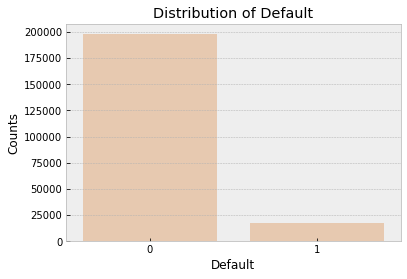

In [32]:
sns.countplot(x='target',data = df_train, alpha=0.5, color='sandybrown')
plt.xlabel('Default')
plt.ylabel('Counts')
plt.title('Distribution of Default');
print('Global Default rate is {}%'.format(df_train.target.mean().round(4)*100))

__8.07%__ of the loans are defaulted.

## Distribution of features & relationship with target

In [33]:
# To track modified features : 
# eg combine levels with few records into one level called 'Others' 
modified_features = dict()

In [34]:
# From Pandas Cookbook 1.X
def flatten_cols(df):
    df.columns = ['_'.join(x) for x in
        df.columns.to_flat_index()]
    return df

In [35]:
# To plot categorical featues.
# We plot categories on x-axis, default rate on primary y-axis & number of observations on secondary y axis.
# Plotting number of observations indicated the credibility of default rate.
def plot_default_cat_feat(df, var, var_desc, sort_by = None):
    """
    Plot default rate for different categories in the feature
    
    Keyword arguments:
    df -- DataFrame
    var -- categorical feature to be grouped by
    var_desc -- description of the feature to be displayed as label 
    sort_by -- specifies how the aggregated dataframe is sorted.  If it is
                'default_rate' -- categories are sorted by default rate in ascending order
                'count' -- categories are sorted by record counts in descending order
                None -- no sorting is done
    
    Missing values are represented by 'Missing' level.
    """

    with plt.style.context('bmh'):
        # aggregate the data
        df_grouped = df.groupby(var,dropna=False).agg({'target':['mean'],'sk_id_curr':['count']}).pipe(flatten_cols)
        df_grouped.index = df_grouped.index.fillna('Missing')

        # sorting
        if sort_by == 'count':
            df_grouped.sort_values(by='sk_id_curr_count',ascending=False,inplace=True)
        elif sort_by == 'default_rate':
            df_grouped.sort_values(by='target_mean',ascending=True,inplace=True)
        
        # plotting default rate on primary y-axis
        fig, ax = plt.subplots()
        # plt.rcParams['figure.dpi']= 480
        fontsize = 15
        # Increase the size of graph when we have more than 4 categories
        if df_grouped.shape[0] > 4:
            fig.set_size_inches(9,6)
            fontsize = 12
            plt.xticks(rotation=45, ha='right')
        ax.plot(df_grouped.index, df_grouped.target_mean, 'o--', color= 'red',alpha=0.6)
        # Add value labels for dafault rates
        #source : https://stackoverflow.com/questions/59143306/add-label-values-to-bar-chart-and-line-chart-in-matplotlib
        line = ax.lines[0]
        for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
            label = "{:.1%}".format(y_value)
            ax.annotate(label,(x_value, y_value), xytext=(0, 5), textcoords="offset points",
                        fontsize=fontsize,color = 'red',ha='center', va='bottom') 
            
        ax.set_title('Default Rate by '+var_desc)
        ax.set_ylabel('Default Rate')
        ax.set_xlabel(var_desc)
        ax.set_facecolor('lavenderblush') #background color
        
        # setting the y-axis limit
        ax.set_ylim(ymin=0,ymax=df_grouped.target_mean.max()+0.05)
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        
        # plotting count of records on secondary y-axis
        ax2 = plt.twinx()
        ax2.bar(df_grouped.index,df_grouped.sk_id_curr_count,
                    alpha=0.3, color='sandybrown')
        ax2.set_ylabel('Counts')
        ax2.grid(False)
        
        # Add legends for both y axes
        # source: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
        # https://mpltest2.readthedocs.io/en/stable/gallery/recipes/transparent_legends.html
        fig.legend(labels=('Default Rate','Counts'),loc='upper right',bbox_to_anchor=(1,1),
                   bbox_transform=ax.transAxes,fancybox=True, framealpha=0.2)
        sns.despine(left=True,bottom=True,)
        plt.tight_layout()
        plt.show();


In [36]:
# To plot continuous features. We first convert continuous feature into suitable bins.
# Then we plot bins on x-axis, default rate on primary y-axis & number of observations on secondary y axis.
# Plotting number of observations indicated the credibility of default rate.

def plot_default_cont_feat(df, var, var_desc, n = 10, pct_range = (0.0,1.0), decimals = 0 ):
    """
    Plot default rate for continuous feature. We bin continuous feature & then plot default rate & count of observation.
    
    Keyword arguments:
    df -- DataFrame
    var -- categorical feature to be grouped by
    var_desc -- description of the feature to be displayed as label 
    n -- number of bins
    pct_range -- percentile range used for plotting. Values outside this range will be excluded.
    decimals -- to tune number of bins. eg if a feature has [0,1] range, then decimal is 
                atleast 2 to avoid duplicate bins.
                
    """
    df_temp = df[[var,'target','sk_id_curr']].copy()
    l_pct = pct_range[0]
    u_pct = pct_range[1]
    f_min = df_temp[var].quantile(l_pct) - 1/(10**decimals) # 0.01 added to that lower value is not excluded
    f_max = df_temp[var].quantile(u_pct) + 1/(10**decimals)
    mod_var = 'mod'+'_'+ var
    intvl = pd.interval_range(start=f_min, end= f_max, periods= n)
    # Round lower and upper limits of interval
    intvl = pd.IntervalIndex([ pd.Interval( round(i.left,decimals), 
                                round(i.right,decimals), i.closed ) for i in intvl ])
    df_temp.loc[:,mod_var]= pd.cut(df_temp[var],intvl)
    print('Count of missing observations : {}'.format(df_temp.loc[:,var].isna().sum()))
    excluded_obs = df_temp.loc[:,mod_var].isna().sum() - df_temp.loc[:,var].isna().sum()
    print('Count of excluded observations: {}'.format(excluded_obs))
    df_grouped = df_temp.groupby(mod_var,dropna=False).agg({'target':['mean'],'sk_id_curr':['count']}).pipe(flatten_cols)
    del df_temp  
    with plt.style.context('bmh'):
        # plotting default rate on primary y-axis
        fig, ax = plt.subplots()
        fig.set_size_inches(9,6)
        
        plt.xticks(rotation=45, ha='right')
        ax.plot(df_grouped.index.astype('str'), df_grouped.target_mean, 'o--', color= 'red',alpha=0.6)
        ax.set_title('Default Rate by '+var_desc)
        ax.set_ylabel('Default Rate')
        ax.set_xlabel(var_desc)
        ax.set_facecolor('lavenderblush') #background color
        
        # setting the y-axis limit
        ax.set_ylim(ymin=0,ymax=df_grouped.target_mean.max()+0.05)
        ax.yaxis.set_major_formatter(PercentFormatter(1))
        line = ax.lines[0]
        for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
            label = "{:.1%}".format(y_value)
            ax.annotate(label,(x_value, y_value), xytext=(5, 5), textcoords="offset points",
                        fontsize=10,color = 'red',ha='center', va='bottom') 
        
        # plotting count of records on secondary y-axis
        ax2 = plt.twinx()
        ax2.bar(df_grouped.index.astype('str'),df_grouped.sk_id_curr_count,
                    alpha=0.3, color='sandybrown')
        ax2.set_ylabel('Counts')
        ax2.grid(False)
        
        # Add legends for both y axes
        # source: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
        # https://mpltest2.readthedocs.io/en/stable/gallery/recipes/transparent_legends.html
        fig.legend(labels=('Default Rate','Counts'),loc='upper right',bbox_to_anchor=(1,1),
                   bbox_transform=ax.transAxes,fancybox=True, framealpha=0.2)
        sns.despine(left=True,bottom=True,)
        plt.tight_layout()
        plt.show();

In [37]:
def create_top_n_cat_feat(df,var,n=5,prefix='mod'):
    """
    Create new feature with top n categories and 'Others'
    
    Keyword arguments:
    df -- DataFrame
    var -- categorical feature to modify
    n -- top number of categories by count to keep as they are. Remaining categories are labeled as 'Others'
    prefix -- prefix to add when naming new feature. New feature will have name as prefix_var
    
    """
    
    top_n = df[var].value_counts().index[:n]
    new_var = prefix+'_' + var
    df = df.assign( **{new_var : df[var].where(         # Dynamically assigns name to new column
                            df[var].isin(top_n),
                            'Others')} )
    return df

### Portfolio

What loan portfolio do we have ?  

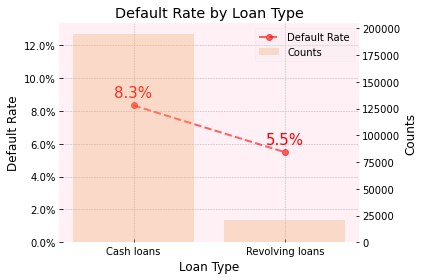

In [38]:
plot_default_cat_feat(df_train,'name_contract_type','Loan Type')

90% loans are cash loans and cash loans, on average, have a higher default rate.

### Types of Client

What types of clients we generally lend to ?

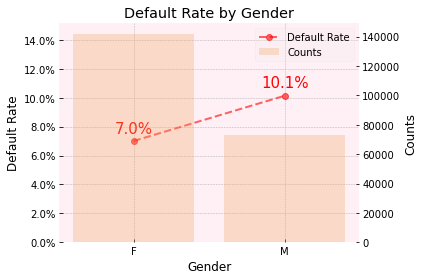

In [39]:
plot_default_cat_feat(df_train,'code_gender','Gender')

~65% of applicants are females. Females are on average 3% points better than males in paying back the loans.

Count of missing observations : 0
Count of excluded observations: 0


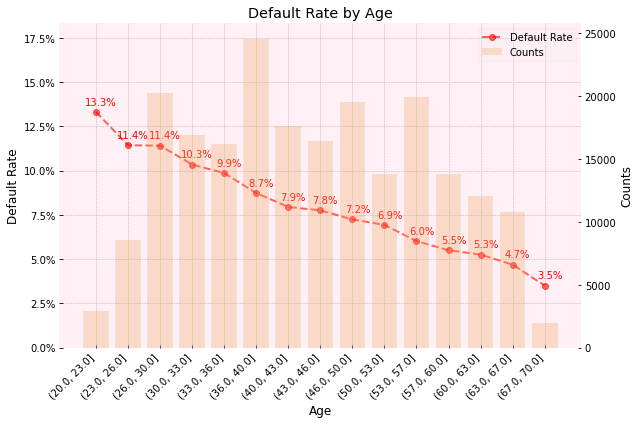

In [40]:
df_train.loc[:,'mod_days_birth'] = (df_train.loc[:,'days_birth'].copy()/(-365.25))
plot_default_cont_feat(df_train,'mod_days_birth','Age',n=15,pct_range=(0.0,1))

Client’s age is within a reasonable range of 21-69. Home credit lends to clients across all ages. We can clearly see that the default rate decreases as age increases. Average risk differentiation between the 2nd youngest and the 2nd last oldest groups is more than 7% points.

Is decreasing default rate consistent for male and females ?

Count of missing observations : 0
Count of excluded observations: 0


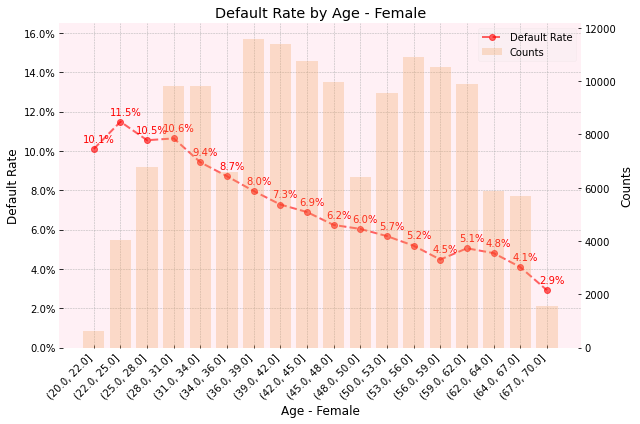

Count of missing observations : 0
Count of excluded observations: 0


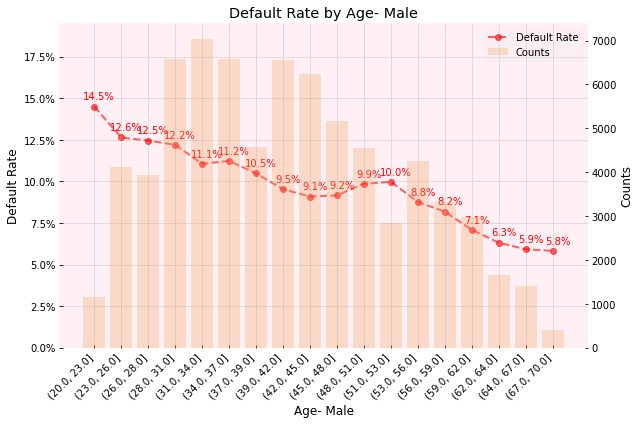

In [41]:
df_train_f = df_train.loc[df_train.code_gender =='F',].copy()
plot_default_cont_feat(df_train_f,'mod_days_birth','Age - Female',n=18,pct_range=(0.0,1))

df_train_m = df_train.loc[df_train.code_gender =='M',].copy()
plot_default_cont_feat(df_train_m,'mod_days_birth','Age- Male',n=18,pct_range=(0.0,1))

del df_train_f, df_train_m

From age 28 to 56, default rate steeply decreases as female age increases. But, decrease in default rate is slower for males in the same age range. This is indicating an __interaction__ bwtween age and gender features.

In [42]:
df_train = df_train.drop(columns = ['mod_days_birth'])

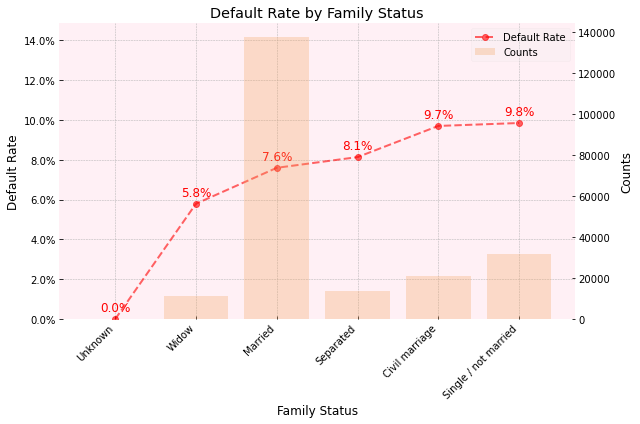

In [43]:
plot_default_cat_feat(df_train,'name_family_status','Family Status','default_rate')

Almost 50% of the clients come from a family of 2. And this group seems to have the lowest default rate.

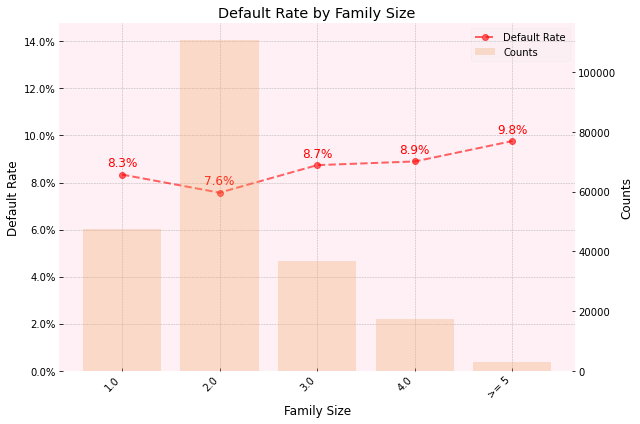

In [44]:
df_train = df_train.assign( mod_cnt_fam_members = np.where(
            df_train.cnt_fam_members <= 4, 
            df_train.cnt_fam_members.astype('str'), 
            '>= 5')
            )
plot_default_cat_feat(df_train,'mod_cnt_fam_members','Family Size')

More than 50% loans are given to working professionals. Pensioners and State servants are having much lower average default rate than working professionals.

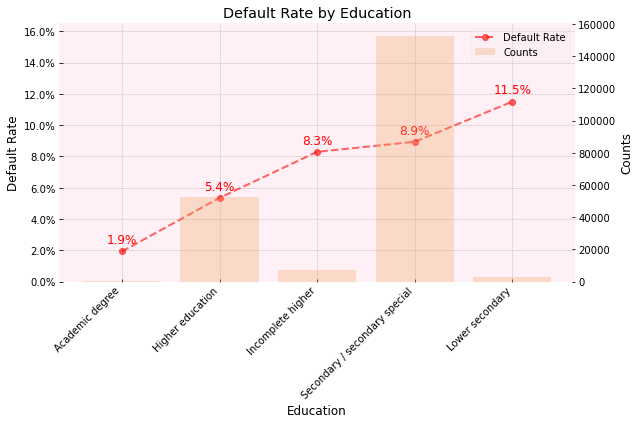

In [45]:
del df_train['mod_cnt_fam_members']
plot_default_cat_feat(df_train,'name_education_type','Education','default_rate')

~ 70% of the clients fall into the secondary education category and ~25% of clients fall into the higher education category. Higher the education, lower the default rate.

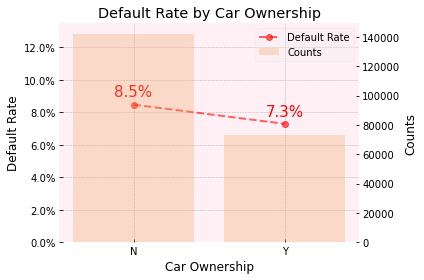

In [46]:
plot_default_cat_feat(df_train,'flag_own_car','Car Ownership')

~65% clients own a car and their default rate is lower.

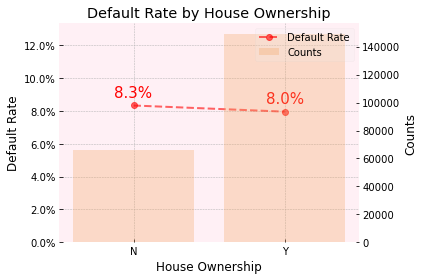

In [47]:
plot_default_cat_feat(df_train,'flag_own_realty','House Ownership')

~65% clients own a house. Default rate is similar for both the groups.

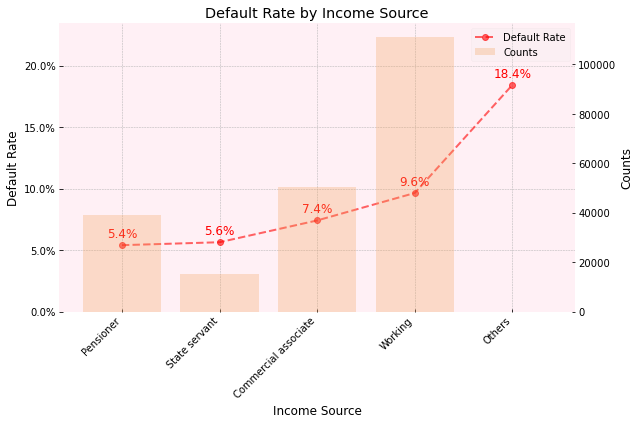

In [48]:
df_train = create_top_n_cat_feat(df_train,var='name_income_type',n=4)
modified_features['name_income_type'] = 'mod_name_income_type'
plot_default_cat_feat(df_train,'mod_name_income_type','Income Source','default_rate')

More than 50% loans are given to working professionals. Pensioners and State servants are having much lower average default rate than working professionals.

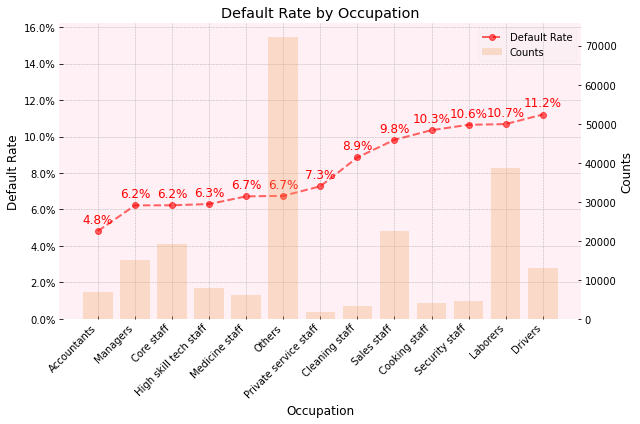

In [49]:
df_train = create_top_n_cat_feat(df_train,var='occupation_type',n=12)
modified_features['occupation_type'] = 'mod_occupation_type'
plot_default_cat_feat(df_train,'mod_occupation_type','Occupation','default_rate')

We have too many categories with few observations. Hence, we are looking at top 12 categories and remaining categories are combined into 'Others'. Desk labourers tend to have lower default rate.

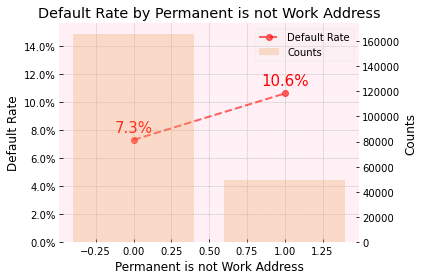

In [50]:
plot_default_cat_feat(df_train,'reg_city_not_work_city','Permanent is not Work Address')

For 80% of clients, permanant address is same as work address. These clients tend to have lower default rate.

Count of missing observations : 0
Count of excluded observations: 0


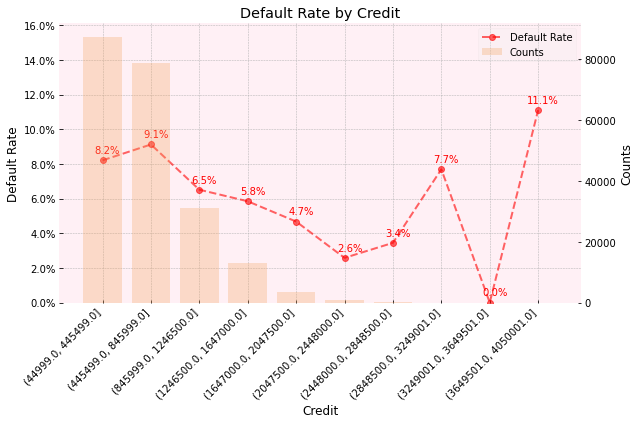

In [51]:
plot_default_cont_feat(df_train,'amt_credit','Credit',n=10,pct_range=(0.0,1))

We have some extreme outliers with less observations at higher credit amounts. This is leading to high volatility in the last 5 bins. Therefore, rather than combining the top 1 percentile with lower percentiles, we would remove the top 1 percentile so that  trend is not distorted. 

Count of missing observations : 0
Count of excluded observations: 2153


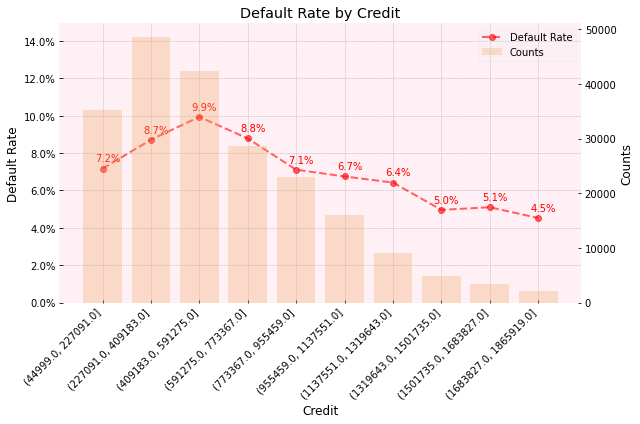

In [52]:
plot_default_cont_feat(df_train,'amt_credit','Credit',n=10,pct_range=(0.0,0.99))

We can see an inverted V type trend. Initially, with increases in credit amount, the default rate increases and it peaks around the median. Then it starts decreasing again.
For higher credit amounts, the underwriting process can be stricter than usual. We can ask business about the validity of these trends. We see __similar distribution and trends in annuity and goods price amounts__ features. 

Count of missing observations : 0
Count of excluded observations: 2152


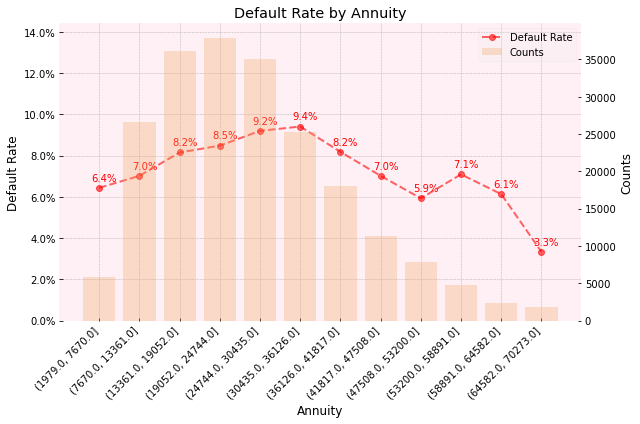

In [53]:
plot_default_cont_feat(df_train,'amt_annuity','Annuity',n=12,pct_range=(0.0,0.99))

Count of missing observations : 192
Count of excluded observations: 1010


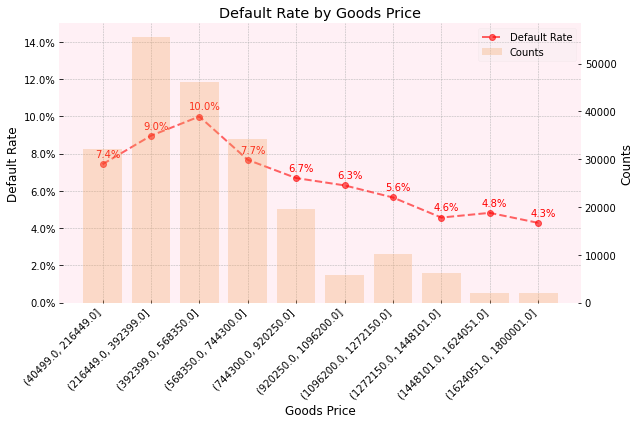

In [54]:
plot_default_cont_feat(df_train,'amt_goods_price','Goods Price',n=10,pct_range=(0.0,0.99))

Count of missing observations : 0
Count of excluded observations: 0


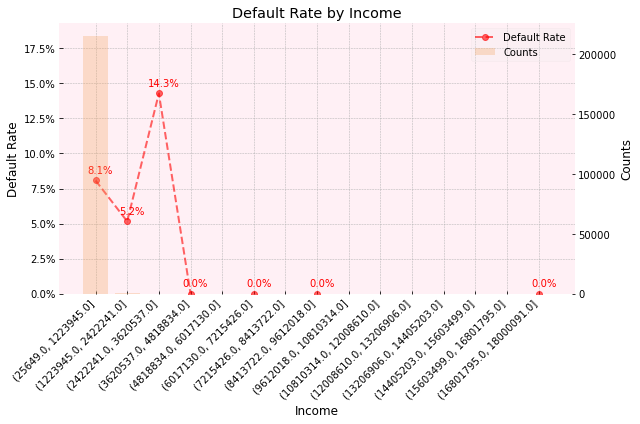

In [55]:
plot_default_cont_feat(df_train,'amt_income_total','Income',n=15,pct_range=(0.0,1))

In [56]:
df_train.amt_income_total.describe(percentiles = [0.95, 0.97, 0.99])

count    2.152490e+05
mean     1.684973e+05
std      1.093618e+05
min      2.565000e+04
50%      1.485000e+05
95%      3.375000e+05
97%      3.825000e+05
99%      4.725000e+05
max      1.800009e+07
Name: amt_income_total, dtype: float64

We have extreme outliers in income. The highest value for income is 117,000,000 seems odd when 95th percentile is 382,500. Based on information by Home Credit, income represents monthly income. It is a self-declared field which is not verified. It can be a data entry error of additional zeros or intentionally, client had declared high income to avail the loan. Let us exclude op 3 percentiles.

Count of missing observations : 0
Count of excluded observations: 5804


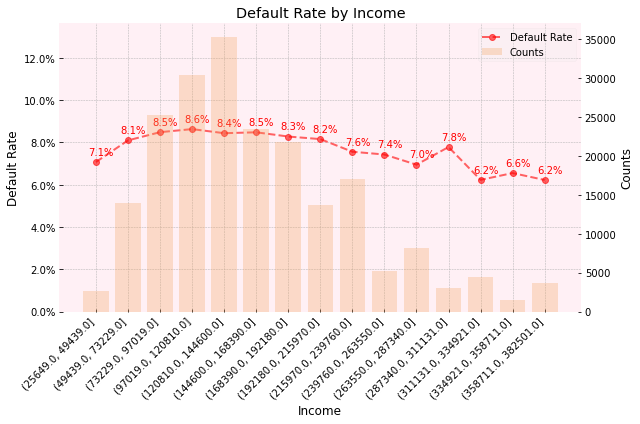

In [57]:
plot_default_cont_feat(df_train,'amt_income_total','Income',n=15,pct_range=(0.0,0.97))

Default rate is increasing till around median income and then again decreasing with increase in income. This looks like a inverted U pattern. 

Count of missing observations : 38881
Count of excluded observations: 8797


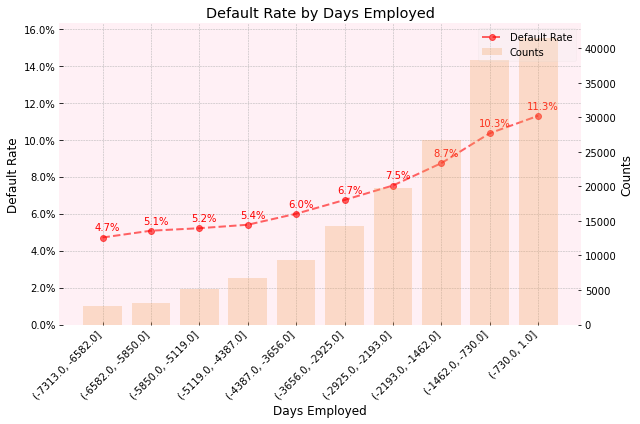

In [58]:
plot_default_cont_feat(df_train,'days_employed','Days Employed',n=10,pct_range=(0.05,1))

Days employed are relative to application date, hence negative. From lfeft to right, days employed decreases. Missing days employed indicate Pentioners. Higher the days employed, lower the default rate. But as days employed is related to age of the person, it is difficult to know about this trend.

Count of missing observations : 0
Count of excluded observations: 210


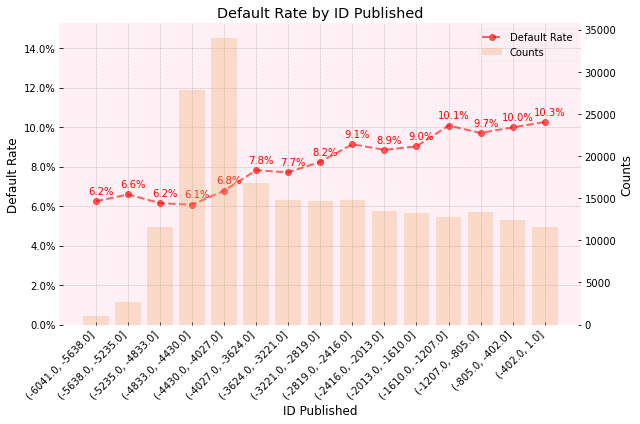

In [59]:
plot_default_cont_feat(df_train,'days_id_publish','ID Published',n=15,pct_range=(0.001,1))

Days are relative to the day of application, hence negative. On average, the older the ID used for application, the lower the default rate. This feature may be related with age.  

Count of missing observations : 1
Count of excluded observations: 2144


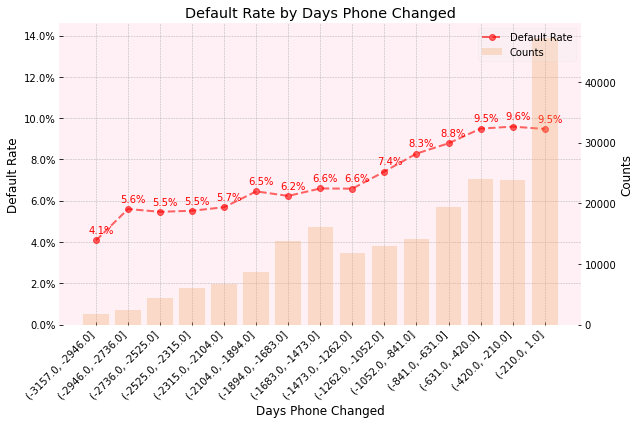

In [60]:
plot_default_cont_feat(df_train,'days_last_phone_change',
                       'Days Phone Changed',n=15,pct_range=(0.01,1))


Days are relative to the day of application, hence negative. On average, the older the phone, the lower the default rate. 

### History of Client with Home Credit

We have data on past applications of the clients. Features of last applications are different and limited. Does the given past of the client help us predict default rate ? 

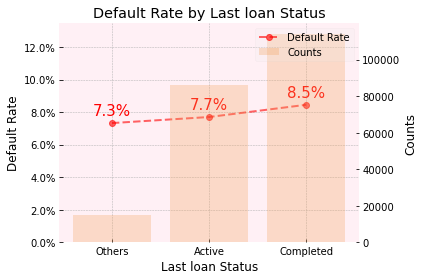

In [61]:
df_train = create_top_n_cat_feat(df_train,var='pc_latest_contract_status_last',n=2)
modified_features['pc_latest_contract_status_last'] = 'mod_pc_latest_contract_status_last'

plot_default_cat_feat(df_train,'mod_pc_latest_contract_status_last',
                      'Last loan Status','default_rate')

Clients with active loans have lower default rate.

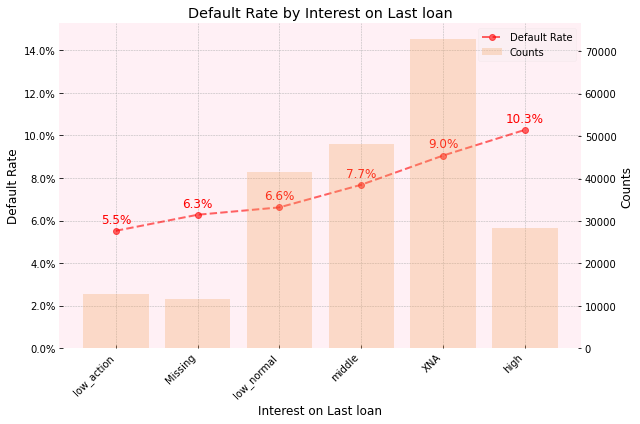

In [62]:
plot_default_cat_feat(df_train,'name_yield_group_last','Interest on Last loan','default_rate')

XNA interest rate is not defined in the data dictionary. Default rate is higher for higher interest offered. This is in some way a confirmation of the existing lending process.

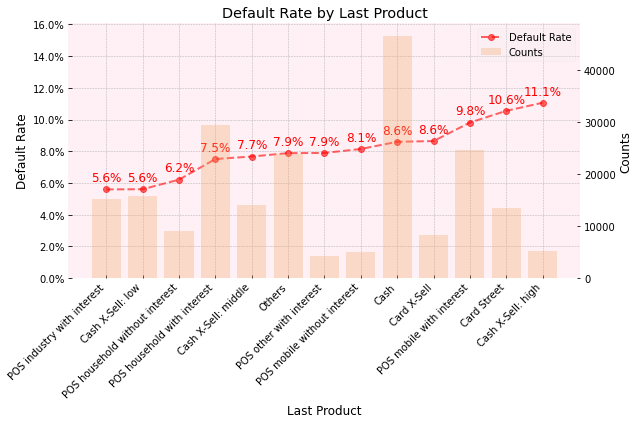

In [63]:
df_train = create_top_n_cat_feat(df_train,var='product_combination_last',n=12)
modified_features['product_combination_last'] = 'mod_product_combination_last'
plot_default_cat_feat(df_train,'mod_product_combination_last','Last Product','default_rate')

Default rate varies by products purchased last time. It will be good to have an understanding of products. Are they offered based on risk ?

Count of missing observations : 12729
Count of excluded observations: 1954


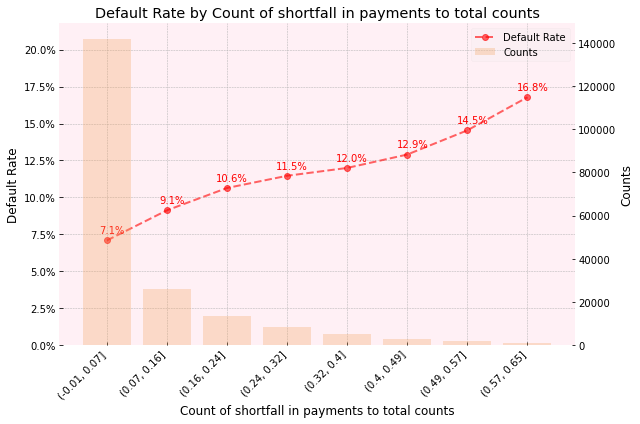

In [64]:
plot_default_cont_feat(df_train,'in_rt_cnt_deficit_pmt_mean','Count of shortfall in payments to total counts',
                       n=8,pct_range=(0.0,0.99),decimals=2)

In [65]:
df_train.in_rt_cnt_deficit_pmt_mean.value_counts().head(2)

0.000000    117626
0.142822      1887
Name: in_rt_cnt_deficit_pmt_mean, dtype: int64

This is a derived feature from installment dataset. We count the number of times there was a shortfall in minimum installment payment. Then we normalize this count by the total number of installments due.   
55% applications have paid required minimum installments amounts or more, indicated by 1st bin where all observed values are zeros. But as the deficit count increases, the default rate increases. This is intuitive as someone who is unable to pay the minimum installment amount is more likely to default. (~6% applications do not have past history and are missing and we are excluding top 1 percentile observations.)

Count of missing observations : 12724
Count of excluded observations: 9786


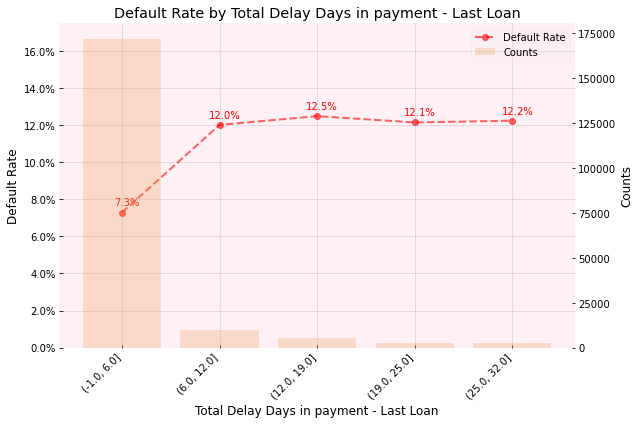

In [66]:
plot_default_cont_feat(df_train,'in_sum_payment_delay_last','Total Delay Days in payment - Last Loan',
                       n=5,pct_range=(0.0,0.95),decimals=0)

This feature is derived as sum of days past due payment date in servicing the last loan. More the delay, the higher the default rate.

### External Source Features

Count of missing observations : 475
Count of excluded observations: 0


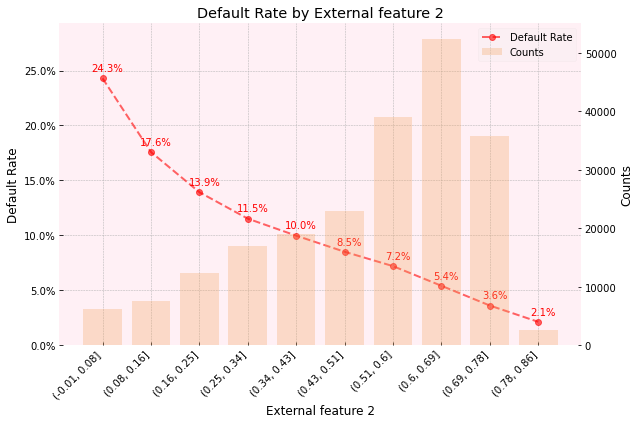

In [67]:
plot_default_cont_feat(df_train,'ext_source_2','External feature 2',n=10,
                       pct_range=(0.0,1),decimals=2)

This looks like a normalized feature. As the value of this feature starts approaching 1, the default rate starts decreasing. This feature is exhibiting a strong downward trend with excellent risk differentiation. 

We also have external features 1 & 3 with similar trends. But they have 56% and 20% missing values respectively. Whereas the external feature 2 has just 0.2% missing values. We will drop external feature 1.

Count of missing observations : 42751
Count of excluded observations: 0


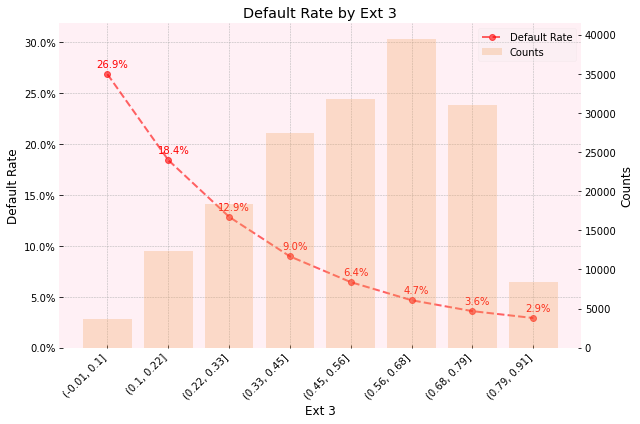

In [68]:
plot_default_cont_feat(df_train,'ext_source_3','Ext 3',n=8,
                       pct_range=(0.0,1.0), decimals=2)

In [69]:
df_train[df_train.ext_source_3.isna()].target.mean()

0.09426680077659003

Dropping newly created features.

In [70]:
# df_train.drop(modified_features.values(),axis=1)
df_train.drop(columns = list(modified_features.values()),  inplace=True)

### Correlations

Now that we have a sense of what features can be predictive of loan default rate, we can look at understanding relationship between features using correlation. We will also look at correlation between feature and target variable. Along the way, we identify features to drop based on high correlation and high missing values. 

#### Property Features

These 47 feaures are related to house, apartment and surrounding areas. They may be correlated.
As we had seen before, property feaures have missing values in the range 47% to 69%.
With so many missing values, we would look at correlation to reduce number of features rather than doing PCA. 

In [71]:
prop_corr_matrix = df_train[prop_col].corr()

In [72]:
prop_corr_matrix.shape

(43, 43)

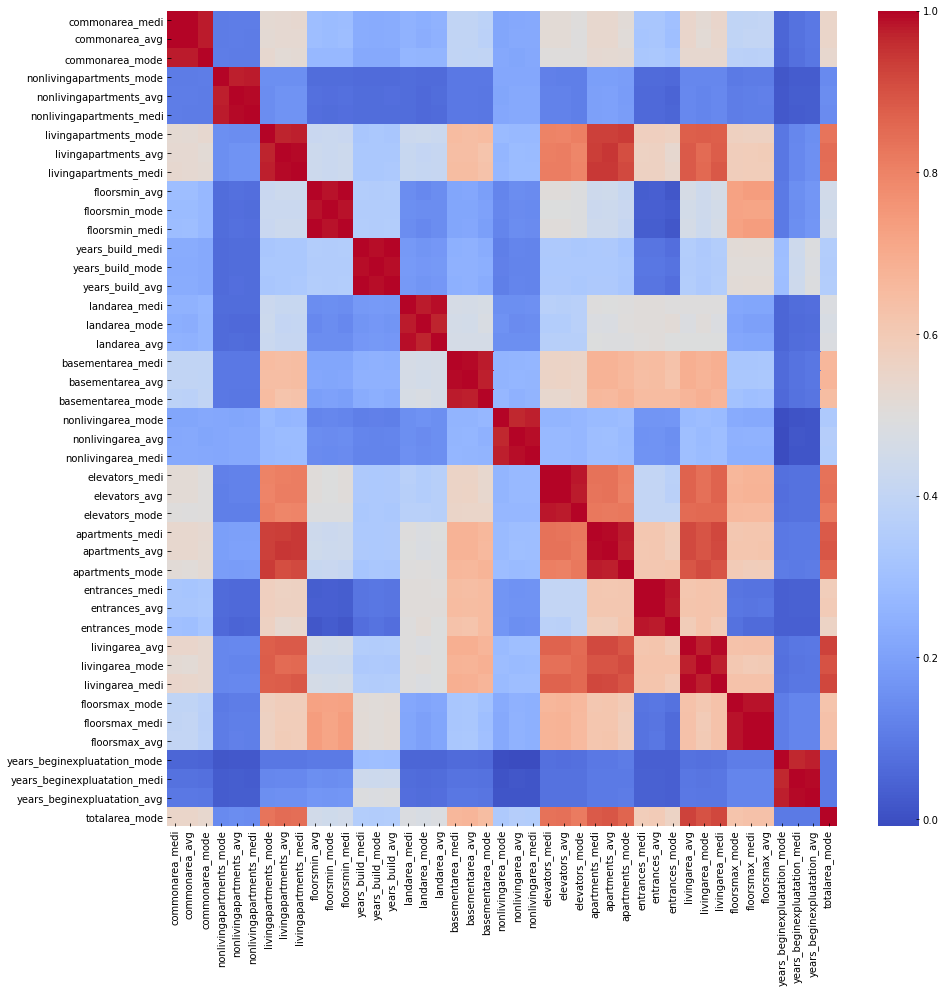

In [73]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(prop_corr_matrix, cmap= 'coolwarm');

Looking at correlation heatmap, 3 of things are clear.
1. We have positive correlation between features.
2. We have 3 different derivations of the same feature : median, mode, average. These 3 derivations are more than 95% correlated with each other. 
3. Living area, living apartments, elevators, apartments and total area are ~90% correlated with each others. Total area has just the mode feature.

Let's pick the feature which is more correlated to target to represent each group.

In [74]:
target_prop_corr = pd.DataFrame( df_train[prop_col].corrwith(df_train.target)
                                .sort_values(),columns=['corr_with_target %'])
target_prop_corr.head(15).round(4)*100

,corr_with_target %
floorsmax_avg,-4.30
floorsmax_medi,-4.28
floorsmax_mode,-4.19
floorsmin_avg,-3.51
floorsmin_medi,-3.48
floorsmin_mode,-3.32
elevators_avg,-3.26
livingarea_avg,-3.24
elevators_medi,-3.23
livingarea_medi,-3.22


In [75]:
target_prop_corr.tail(15).round(4)*100

,corr_with_target %
commonarea_avg,-1.80
entrances_mode,-1.75
commonarea_mode,-1.58
nonlivingarea_avg,-1.32
nonlivingarea_medi,-1.27
nonlivingarea_mode,-1.16
landarea_medi,-1.13
landarea_avg,-1.10
landarea_mode,-1.00
years_beginexpluatation_medi,-0.98


1. Of the 3 derivations, average is more correlated with target than mode and median.
2. We can pick livingarea_avg feature to represent those 5 feaures because of high correlation with target and better distribution spread. 

In [76]:
bool_floor = ~df_train.floorsmax_avg.isna()
stats.pointbiserialr(df_train.loc[bool_floor,'target'],
                     df_train.loc[bool_floor,'floorsmax_avg'])

PointbiserialrResult(correlation=-0.042974010922140385, pvalue=2.1774581459316443e-45)

Correlation between floorsmax_avg & target is significant. Let's plot the default rate trend.

Count of missing observations : 107094
Count of excluded observations: 772


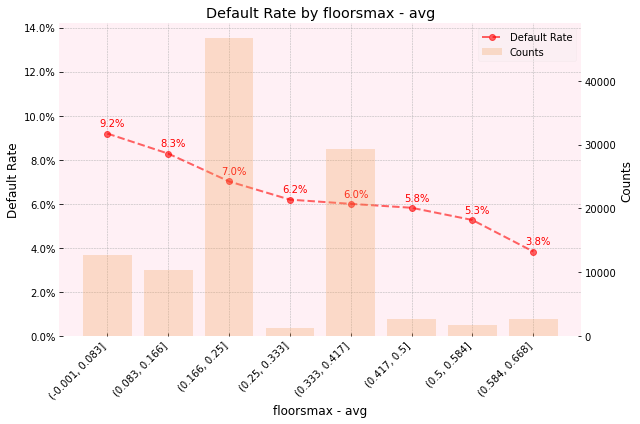

In [77]:
plot_default_cont_feat(df_train,'floorsmax_avg','floorsmax - avg',n=8,
                       pct_range=(0.0,.99),decimals=3)

We get a visual confirmation by observing decreasing trend. Hence, we will pick average over mean and mode.

We will drop following features ownening to high missing %.

In [78]:
high_miss_prop = ['commonarea_avg','nonlivingapartments_avg',
                  'livingapartments_avg']
missing_col.loc[high_miss_prop,].head()

,Missing %
Feature,
commonarea_avg,69.9
nonlivingapartments_avg,69.4
livingapartments_avg,68.4


Based on above analysis, below is the list of property features to drop.

In [79]:
prop_num_drop = ['commonarea_medi', 'commonarea_mode','commonarea_avg',
            'nonlivingapartments_mode', 'nonlivingapartments_medi', 'nonlivingapartments_avg',
            'livingapartments_mode', 'livingapartments_medi', 'livingapartments_avg',
            'floorsmin_mode','floorsmin_medi', 
            'years_build_medi', 'years_build_mode', 'years_build_avg',
            'landarea_medi', 'landarea_mode',
            'basementarea_medi', 'basementarea_mode',
            'nonlivingarea_mode','nonlivingarea_medi', 'nonlivingarea_avg',
            'elevators_medi', 'elevators_mode', 'elevators_avg',
            'apartments_medi', 'apartments_avg', 'apartments_mode',
            'entrances_medi', 'entrances_avg', 'entrances_mode', 
            'livingarea_mode', 'livingarea_medi',
            'floorsmax_mode', 'floorsmax_medi',
            'years_beginexpluatation_mode', 'years_beginexpluatation_medi',
            'years_beginexpluatation_avg',
            'totalarea_mode']

In [80]:
set(prop_col)-set(prop_num_drop)

{'basementarea_avg',
 'emergencystate_mode',
 'floorsmax_avg',
 'floorsmin_avg',
 'fondkapremont_mode',
 'housetype_mode',
 'landarea_avg',
 'livingarea_avg',
 'wallsmaterial_mode'}

#### Missing values

What is the default rate for missing values in floorsmax_avg ?

In [81]:
df_train.loc[df_train.floorsmax_avg.isna(),].target.mean().round(3)*100

9.2

This default rate is similar to default rate for lowest bin, containing 0 values.
Hence, we will replace missing with 0 values.  
Similarly, as noted for other features, we will reaplce missing with 0 values.

#### Dropping property columns

In [82]:
df_train_dimR = df_train.drop(columns = prop_num_drop)

In [83]:
df_train_dimR.shape

(215249, 191)

In [84]:
non_prop_num = set(num_features) - set(prop_num_drop)
corr_matrix = df_train_dimR[non_prop_num].corr()

In [85]:
corr_matrix

,amt_req_credit_bureau_qrt,ext_source_3,days_registration,bc_cnt_consumer_credit,in_cnt_payment_sum,pc_max_sk_dpd_max,loan_durtn_1st_ver_mean,rt_credit_application_mean,bc_cnt_active,obs_60_cnt_social_circle,cr_max_amt_cr_limit_max,amt_annuity_mean,rt_annuity_credit_mean,obs_30_cnt_social_circle,in_sum_payment_advance_mean,in_sum_payment_delay_mean,bc_cnt_cr_status_others,bc_cnt_mortgage,nflag_insured_on_approval_sum,bc_sum_cnt_credit_prolong,amt_req_credit_bureau_mon,rt_payment_advance_mean,days_last_phone_change,rt_credit_application_last,amt_annuity,in_sum_payment_delay_max,cr_max_sk_dpd_last,amt_income_total,amt_req_credit_bureau_day,days_decision_mean,rt_payment_delay_mean,cnt_payment_mean,pc_max_sk_dpd_def_max,rate_down_payment_last,amt_req_credit_bureau_year,rt_payment_delay_last,region_population_relative,bc_cnt_credit_type,cr_sum_cnt_drawings_curr_sum,cr_rt_max_balance_cr_max,bc_cnt_loans,in_sum_payment_advance_max,amt_credit_last,amt_credit_max,def_30_cnt_social_circle,rt_credit_application_max,bc_cnt_credit_card,cr_sum_cnt_drawings_curr_mean,in_rt_cnt_deficit_pmt_max,rt_payment_advance_last,...,cr_rt_max_payment_inst_max,in_rt_amt_deficit_inst_max,floorsmin_avg,prev_cnt_pt_x-sell,hour_appr_process_start,in_rt_cnt_deficit_pmt_mean,rt_annuity_credit_max,ext_source_1,bc_last_days,cnt_fam_members,in_rt_amt_surplus_inst_max,livingarea_avg,in_cnt_payment_mean,bc_amt_max_credit_overdue,own_car_age,days_decision_last,bc_cnt_car_loan,in_sum_payment_delay_last,nflag_last_appl_in_day_sum,def_60_cnt_social_circle,cr_max_amt_balance_max,amt_annuity_last,nflag_last_appl_per_contract_sum,amt_credit_mean,prev_cnt_ct_cash_loans,prev_cnt_cs_approved,cr_max_sk_dpd_def_last,rate_down_payment_mean,bc_cnt_cr_type_others,landarea_avg,amt_down_payment_mean,prev_cnt_pt_walk-in,cr_max_sk_dpd_def_max,cr_max_sk_dpd_max,in_rt_amt_surplus_inst_last,in_rt_amt_surplus_inst_mean,cr_max_amt_cr_limit_last,in_sum_payment_advance_last,cnt_payment_sum,bb_cnt_unique_loan_obs,in_rt_cnt_surplus_pmt_mean,prev_cnt_ct_consumer_loans,amt_goods_price_mean,floorsmax_avg,cr_max_amt_payment_tot_max,rt_payment_delay_max,prev_cnt_pt_xna,rate_down_payment_max,amt_down_payment_max,cnt_children
amt_req_credit_bureau_qrt,1.000000,-0.024897,-0.001690,0.002483,0.030572,0.001430,0.033368,0.019489,-0.004495,0.004267,0.012396,0.036372,-0.050963,0.004491,-0.006257,-0.002997,-0.003797,-0.004049,0.040986,-0.001758,-0.004409,-0.024946,-0.001390,0.025124,0.009838,-0.000971,-0.009615,0.013123,-0.002471,0.094407,-0.004618,0.045461,-0.010757,-0.011917,0.069140,-0.010237,-0.001642,-0.003167,0.023657,-0.018005,0.004497,0.011482,-0.028476,0.064086,-0.001400,0.033383,0.002427,0.010608,-0.004215,-0.040358,...,0.005699,-0.006639,-0.003811,0.068162,0.000712,-0.021841,0.000455,-0.003557,-0.002061,-0.003543,0.035930,-0.002326,-0.001641,-0.000369,-0.019863,0.132217,-0.005153,-0.004766,0.115559,-0.000137,-0.004178,0.037286,0.115099,0.012307,0.118074,0.059826,-0.011536,-0.011693,0.019873,0.006301,-0.004661,0.030077,-0.011562,-0.009455,0.025401,0.024299,0.012120,-0.019002,0.069067,0.019469,0.023112,0.021757,0.054082,0.000455,0.002289,-0.000145,0.120005,-0.000372,0.000903,-0.006768
ext_source_3,-0.024897,1.000000,-0.107643,-0.102292,-0.007279,0.002850,-0.015273,-0.079167,-0.390591,-0.000460,0.026698,0.007215,0.051115,0.000031,0.043308,-0.010252,-0.047318,0.009525,0.025264,-0.035229,-0.007681,0.037503,-0.074198,-0.040375,0.030371,-0.013536,0.011270,-0.066256,-0.007918,-0.145149,-0.017203,-0.050831,-0.047415,0.039931,-0.069591,-0.022374,-0.006176,-0.189664,-0.058713,-0.163720,-0.183262,0.040898,0.026703,-0.043126,-0.036345,-0.079167,-0.271988,-0.090620,-0.101613,0.031613,...,0.009554,-0.095144,-0.002719,-0.037630,-0.039713,-0.112178,0.005812,0.186843,-0.293099,-0.027734,0.019162,0.004026,-0.002837,-0.009763,-0.015648,-0.110948,-0.025259,-0.011457,-0.123493,-0.034005,-0.104047,0.027015,-0.122824,-0.003834,-0.098284,0.000591,-0.022653,0.045602,-0.054167,0.007296,0.031950,-0.144140,-0.022629,0.011042,

In [86]:
# from https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# Modified from top n correlations pairs to correlation pairs in specified range
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(corr_matrix, threshold_range = (0.7,1)):
    au_corr = corr_matrix.abs().unstack()
    labels_to_drop = get_redundant_pairs(corr_matrix)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    threshold_bool = (au_corr > threshold_range[0]) & (au_corr <= threshold_range[1])
    return au_corr[threshold_bool]

In [87]:
df_corr_90 = pd.DataFrame(get_top_abs_correlations(corr_matrix,(0.9,1)).round(4)*100)
df_corr_90.reset_index(inplace=True)
df_corr_90 = df_corr_90.drop([0,1],axis=0)
df_corr_90.columns = ['feature_1','feature_2','absolute corr']
df_corr_90

,feature_1,feature_2,absolute corr
2,cr_sum_cnt_drawings_curr_sum,cr_sum_cnt_drawings_curr_mean,99.92
3,cr_max_sk_dpd_def_last,cr_max_sk_dpd_def_max,99.90
4,obs_60_cnt_social_circle,obs_30_cnt_social_circle,99.84
5,cr_max_amt_cr_limit_max,cr_max_amt_cr_limit_last,99.83
6,amt_credit,amt_goods_price,98.70
7,amt_credit_max,amt_goods_price_max,98.57
8,in_rt_amt_deficit_inst_mean,in_rt_cnt_deficit_pmt_mean,98.50
9,in_rt_cnt_deficit_pmt_max,in_rt_amt_deficit_inst_max,97.88
10,bc_cnt_consumer_credit,bc_cnt_loans,93.20
11,in_sum_payment_delay_mean,in_sum_payment_delay_last,92.89


Above features are having >90% correlation. We will drop the feature which has more missing values within the pair.

In [88]:
l_zero = (missing_col.loc[df_corr_90.feature_1,].values 
          > missing_col.loc[df_corr_90.feature_2,].values)
l_one = (missing_col.loc[df_corr_90.feature_1,].values 
         <= missing_col.loc[df_corr_90.feature_2,].values)

In [89]:
high_corr_col_drop = list(df_corr_90.feature_1.loc[l_zero,]) + list(df_corr_90.feature_2.loc[l_one,])
high_corr_col_drop.remove('amt_goods_price')  # We will keep this important feature in raw form.
high_corr_col_drop

['cr_sum_cnt_drawings_curr_mean',
 'cr_max_sk_dpd_def_max',
 'obs_30_cnt_social_circle',
 'cr_max_amt_cr_limit_last',
 'amt_goods_price_max',
 'in_rt_cnt_deficit_pmt_mean',
 'in_rt_amt_deficit_inst_max',
 'bc_cnt_loans',
 'in_sum_payment_delay_last',
 'bc_cnt_closed',
 'amt_goods_price_mean',
 'bc_cnt_closed']

#### Dropping highly correlated continuous features

In [90]:
df_train_dimR = df_train_dimR.drop(columns=high_corr_col_drop)

In [91]:
df_train_dimR.shape

(215249, 180)

### Cramer's V - For categorical features

In [92]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [93]:
cramers_v(df_train_dimR[cat_features[0]],df_train_dimR[cat_features[1]]), len(cat_features)

(0.010278308330170847, 64)

In [94]:
list_cat_corr = []
for i,f1 in enumerate(cat_features):
    for j in range(i,len(cat_features)):
        f2 = cat_features[j]
        if (i != j):
            corr = cramers_v(df_train_dimR[f1].astype('str'),df_train_dimR[f2].astype('str'))
            list_cat_corr.append([f1,f2,corr])
            

In [95]:
df_cat_corr = pd.DataFrame(list_cat_corr, columns=['feature_1', 'feature_2', 'cramers_v'])
df_cat_corr['cramers_v'] = df_cat_corr['cramers_v'].round(4)*100

In [96]:
df_cat_corr.sort_values(by='cramers_v',ascending=False).head(10)

,feature_1,feature_2,cramers_v
309,name_income_type,flag_emp_phone,99.98
599,flag_emp_phone,organization_type,99.98
888,region_rating_client,region_rating_client_w_city,95.73
1070,reg_region_not_work_region,live_region_not_work_region,86.18
1973,name_yield_group_last,product_combination_last,82.96
1196,reg_city_not_work_city,live_city_not_work_city,82.58
1980,name_payment_type_grp_mode,name_payment_type_last,72.50
2006,channel_type_grp_mode,channel_type_last,70.29
589,flag_emp_phone,occupation_type,69.41
1386,wallsmaterial_mode,emergencystate_mode,68.97


What is the relationship between work phone & income source ?

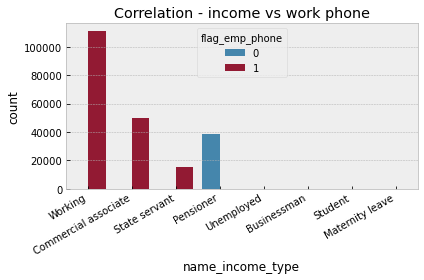

In [97]:
sns.countplot(data = df_train_dimR,x='name_income_type', hue='flag_emp_phone')
plt.xticks(rotation=30, ha = 'right')
plt.title('Correlation - income vs work phone')
plt.tight_layout()

Pensioners did not provide work phone number in credit application. Similar logic applies organization type.

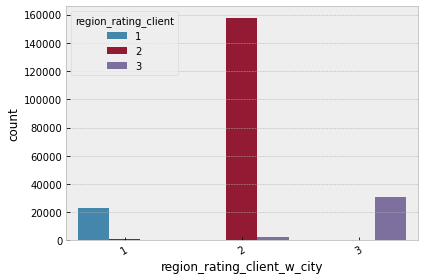

In [98]:
sns.countplot(data = df_train_dimR,x='region_rating_client_w_city', 
              hue='region_rating_client')
plt.xticks(rotation=30, ha = 'center')
plt.tight_layout()

Are products offered based on risks ?

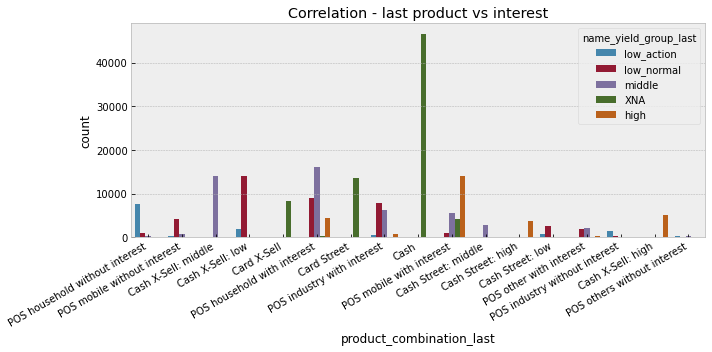

In [99]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data = df_train_dimR,x='product_combination_last', 
              hue='name_yield_group_last')
plt.xticks(rotation=30, ha = 'right')
plt.title('Correlation - last product vs interest')
plt.tight_layout()

Each product has one dominating interest type.

#### Dropping highly correlated categorical features

In [100]:
df_train_dimR = df_train_dimR.drop(columns=['flag_emp_phone','region_rating_client'])
high_corr_col_drop.append(['flag_emp_phone','region_rating_client'])

### Correlation ratio - Between continuous & categorical features.

In [101]:
# source: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [102]:
num_feat_subset = set(num_features) & set(df_train_dimR)
cat_feat_subset = set(cat_features) & set(df_train_dimR)
len(num_feat_subset),len(cat_features)

(113, 64)

In [103]:
df_cat_multilevel = pd.DataFrame(df_train_dimR[cat_feat_subset].nunique(),columns=['nunique'])
cat_multilevel = list(df_cat_multilevel.loc[df_cat_multilevel['nunique'] >2 ,].index)

In [104]:
list_mixed_corr = []
for num_f in num_feat_subset:
    for cat_f in cat_feat_subset:
        corr = correlation_ratio(df_train_dimR[cat_f],df_train_dimR[num_f])
        list_mixed_corr.append([cat_f,num_f,corr])

In [105]:
df_mixed_corr = pd.DataFrame(list_mixed_corr, columns=['feature_1', 'feature_2', 'corr_ratio'])
df_mixed_corr['corr_ratio'] = df_mixed_corr['corr_ratio'].round(4)*100
df_mixed_corr.sort_values(by='corr_ratio',ascending=False).head()

,feature_1,feature_2,corr_ratio
2541,product_combination_last,amt_credit_last,74.78
3016,organization_type,days_birth,63.76
3005,name_income_type,days_birth,62.14
2215,region_rating_client_w_city,region_population_relative,61.51
3324,code_reject_reason_last,prev_cnt_cs_unused_offer,50.45


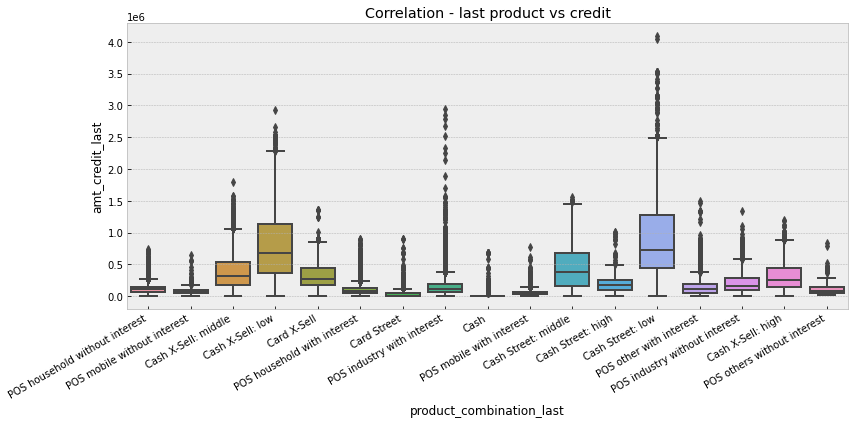

In [106]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data = df_train_dimR,x='product_combination_last',y='amt_credit_last')
plt.xticks(rotation=30, ha = 'right')
plt.title('Correlation - last product vs credit')
plt.tight_layout()

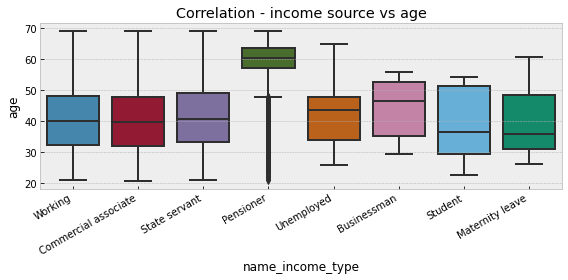

In [107]:
df_train_dimR.loc[:,'age'] = (df_train.loc[:,'days_birth']/(-365.25))
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data = df_train_dimR,x='name_income_type',y='age')
plt.xticks(rotation=30, ha = 'right')
plt.title('Correlation - income source vs age')
plt.tight_layout()

In [108]:
df_train_dimR =  df_train_dimR.drop(columns = ['age'])

In [109]:
df_train_dimR = df_train_dimR.drop(columns = ['ext_source_1'])

In [110]:
df_train_dimR.shape

(215249, 177)

### Feature Importance

Now we find feature importance using a simple xgboost model. One advantage of GBM model is that it handles missing values in a supervised way to reduce the loss. Hence, we do not need to impute those values and we can avoid any biases which may result from imputation of missing values.

We need one-hot encode categorical features. Below categorical features are binary in nature and already present as 0/1 numerical value.

In [111]:
cat_feat_subset_bin = ['reg_city_not_work_city', 'flag_document_3', 'flag_mobil',
       'flag_document_14', 'flag_document_11',
       'flag_phone', 'live_city_not_work_city', 'flag_document_19',
       'flag_document_2', 'flag_document_8', 'live_region_not_work_region',
       'reg_city_not_live_city', 'reg_region_not_live_region',
       'flag_document_4', 'flag_document_5', 'flag_document_17',
       'flag_document_18', 'flag_document_20', 'flag_document_15',
       'flag_document_7', 'flag_document_13', 'flag_document_16',
       'flag_document_9', 'flag_document_6', 'flag_document_10', 'flag_email',
       'flag_document_21', 'flag_cont_mobile', 'reg_region_not_work_region',
       'flag_work_phone', 'flag_document_12']

We will convert region_rating_client_w_city to string as it has 3 rating levels.

In [112]:
df_train_dimR.region_rating_client_w_city = df_train_dimR.region_rating_client_w_city.astype('str')

We will convert following binary variables which are stored are as string to numbers 0/1.

In [132]:
for bin_col in ['code_gender', 'flag_own_car', 'flag_own_realty']:
        df_train_dimR[bin_col], uniques = pd.factorize(df_train_dimR[bin_col])

In [134]:
cat_feat_subset_bin.extend(['code_gender', 'flag_own_car', 'flag_own_realty'])
cat_feat_subset_object = df_train_dimR[cat_feat_subset].select_dtypes(include='object').columns
cat_feat_subset_object

Index(['name_type_suite', 'wallsmaterial_mode', 'channel_type_grp_mode',
       'name_contract_type', 'channel_type_last', 'emergencystate_mode',
       'name_yield_group_last', 'name_education_type', 'housetype_mode',
       'name_client_type_last', 'occupation_type', 'fondkapremont_mode',
       'name_income_type', 'code_reject_reason_grp_mode',
       'cr_latest_contract_status_last', 'pc_latest_contract_status_last',
       'code_reject_reason_last', 'organization_type', 'name_type_suite_last',
       'region_rating_client_w_city', 'weekday_appr_process_start',
       'name_family_status', 'name_payment_type_grp_mode', 'name_housing_type',
       'bb_last_loan_status', 'name_yield_group_grp_mode',
       'name_payment_type_last', 'product_combination_last'],
      dtype='object')

In [135]:
#Check
set(cat_feat_subset) - set(cat_feat_subset_bin) - set(cat_feat_subset_object)

set()

In [136]:
df_train_dummies = pd.get_dummies(df_train_dimR,columns = cat_feat_subset_object, dummy_na=True)

In [137]:
df_train_dummies.shape

(215249, 412)

In [138]:
new_cols = [ col for col in df_train_dummies.columns if col not in df_train.columns]

In [139]:
X_train = df_train_dummies.drop(columns=['target','sk_id_curr'])
y_train = df_train_dummies.target

In [140]:
X_train.head()

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_2,ext_source_3,basementarea_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingarea_avg,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,...,name_payment_type_grp_mode_Cash through the bank,name_payment_type_grp_mode_Cashless from the account of the employer,name_payment_type_grp_mode_Non-cash from your account,name_payment_type_grp_mode_XNA,name_payment_type_grp_mode_nan,name_housing_type_Co-op apartment,name_housing_type_House / apartment,name_housing_type_Municipal apartment,name_housing_type_Office apartment,name_housing_type_Rented apartment,name_housing_type_With parents,name_housing_type_nan,bb_last_loan_status_0,bb_last_loan_status_1,bb_last_loan_status_2,bb_last_loan_status_3,bb_last_loan_status_4,bb_last_loan_status_5,bb_last_loan_status_C,bb_last_loan_status_X,bb_last_loan_status_nan,name_yield_group_grp_mode_XNA,name_yield_group_grp_mode_high,name_yield_group_grp_mode_low_action,name_yield_group_grp_mode_low_normal,name_yield_group_grp_mode_middle,name_yield_group_grp_mode_nan,name_payment_type_last_Cash through the bank,name_payment_type_last_Cashless from the account of the employer,name_payment_type_last_Non-cash from your account,name_payment_type_last_XNA,name_payment_type_last_nan,product_combination_last_Card Street,product_combination_last_Card X-Sell,product_combination_last_Cash,product_combination_last_Cash Street: high,product_combination_last_Cash Street: low,product_combination_last_Cash Street: middle,product_combination_last_Cash X-Sell: high,product_combination_last_Cash X-Sell: low,product_combination_last_Cash X-Sell: middle,product_combination_last_POS household with interest,product_combination_last_POS household without interest,product_combination_last_POS industry with interest,product_combination_last_POS industry without interest,product_combination_last_POS mobile with interest,product_combination_last_POS mobile without interest,product_combination_last_POS other with interest,product_combination_last_POS others without interest,product_combination_last_nan
0,0,0,0,2,45000.0,135000.0,6750.0,135000.0,0.018204,-13349,-2716.0,-3004.0,-4335,NaN,1,0,1,1,0,4.0,12,0,0,0,0,0,0,0.734375,0.667480,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,-1898.0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,1,103500.0,247500.0,12375.0,247500.0,0.020706,-15566,-648.0,-649.0,-4297,NaN,1,0,1,0,0,2.0,7,0,0,0,0,0,0,0.544922,0.845215,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-425.0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,1,0,90000.0,135000.0,6750.0,135000.0,0.025162,-14437,-352.0,-786.0,-5261,NaN,1,0,1,0,0,1.0,9,0,0,0,0,0,0,0.197510,NaN,0.059998,0.333252,0.375,0.0,0.102173,0.0,0.0,0.0,-189.0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,121500.0,254700.0,26874.0,225000.0,0.018845,-19119,-2472.0,-10192.0,-2652,NaN,1,0,1,0,0,2.0,13,0,0,0,0,0,0,0.528809,NaN,NaN,0.166748,NaN,NaN,0.049896,0.0,0.0,0.0,-2090.0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,3,112500.0,247500.0,123

In [141]:
xgb_clf = xgb.XGBClassifier(objective= 'binary:logistic', eta=0.01, n_estimators=200, 
                        max_depth=8, colsample_bytree=0.8, seed=47, use_label_encoder=False)

In [142]:
xgb_clf.fit(X_train, y_train, verbose=True)

[13:19:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=47,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=47,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [143]:
y_pred_probs = xgb_clf.predict_proba(X_train)[:,1]
roc_auc_score(y_train.values, y_pred_probs)

0.8159592791069786

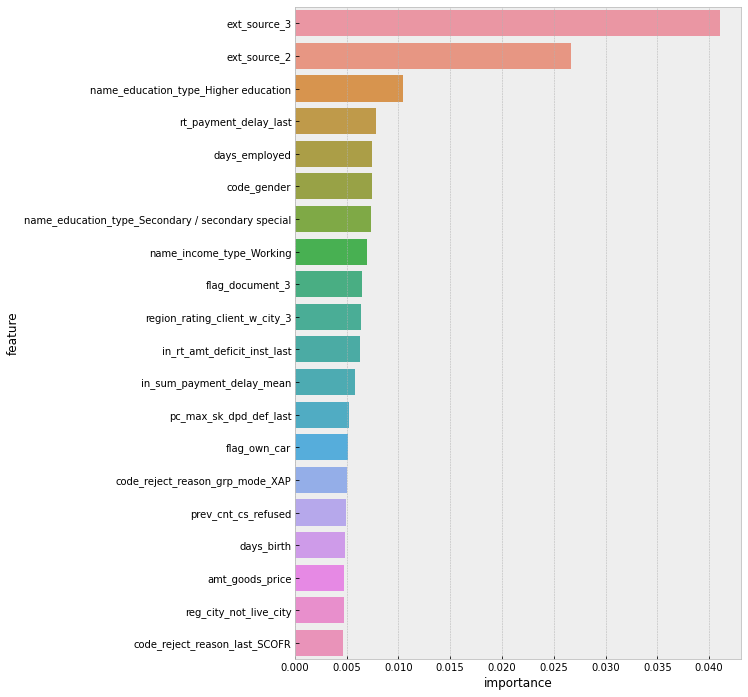

In [144]:
df_feature_imp = pd.DataFrame(X_train.columns,columns=['feature'])
df_feature_imp['importance'] = xgb_clf.feature_importances_
df_feature_imp.sort_values(by='importance', ascending=False, inplace=True)
df_featture_imp_top = df_feature_imp.head(20)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(x ='importance', y='feature', data = df_featture_imp_top)
plt.show()

In [124]:
mapping_col = []

for en_col in new_cols:
    for org_col in cat_feat_subset_object:
        if org_col in en_col :
            mapping_col.append(org_col)
            break

In [125]:
# check
len(mapping_col) == len(new_cols), len(cat_feat_subset_object) == len(set(mapping_col))

(True, False)

In [126]:
df_cat_mapping = pd.DataFrame(zip(mapping_col,new_cols), columns=['original_feature','feature'])

df_feature_imp = df_feature_imp.merge(df_cat_mapping, how='left')
bool_continuous = df_feature_imp.original_feature.isna()
df_feature_imp.loc[bool_continuous, 'original_feature'] = df_feature_imp.loc[bool_continuous,'feature']
df_feature_imp.head()

,feature,importance,original_feature
0,ext_source_3,0.041351,ext_source_3
1,ext_source_2,0.025141,ext_source_2
2,name_education_type_Higher education,0.011077,name_education_type
3,days_employed,0.007894,days_employed
4,rt_payment_delay_last,0.007728,rt_payment_delay_last


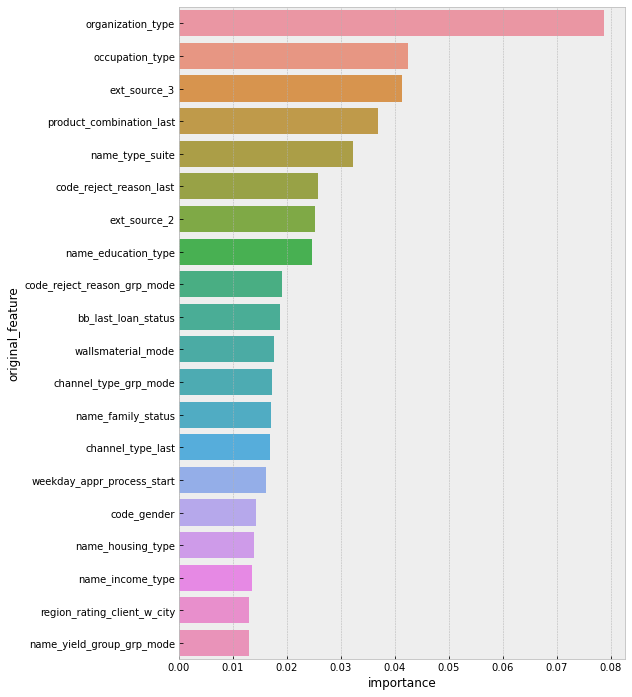

In [127]:
df_feature_imp_grp = df_feature_imp.groupby('original_feature').importance.agg('sum')
df_feature_imp_grp = df_feature_imp_grp.sort_values(ascending=False)
df_feature_imp_grp = df_feature_imp_grp.reset_index()


df_feature_imp_grp_top = df_feature_imp_grp.head(20)

fig, ax = plt.subplots(figsize=(8,12))
sns.barplot(x ='importance', y='original_feature', data = df_feature_imp_grp_top )
plt.show()

In [128]:
df_train_dimR.code_gender.value_counts()

F    141889
M     73360
Name: code_gender, dtype: int64

In [129]:
X_train.code_gender_nan.sum()

0

In [130]:
train_path = '../data/interim/df_train_dimR.csv'
df_train_dimR.to_csv(train_path)

Applying same transformations on test data
1. Dropping highly missing & highly correlatd features
2. Converting datatypes 

In [147]:
df_train_dimR.columns.values

array(['sk_id_curr', 'target', 'name_contract_type', 'code_gender',
       'flag_own_car', 'flag_own_realty', 'cnt_children',
       'amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price',
       'name_type_suite', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type',
       'region_population_relative', 'days_birth', 'days_employed',
       'days_registration', 'days_id_publish', 'own_car_age',
       'flag_mobil', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone',
       'flag_email', 'occupation_type', 'cnt_fam_members',
       'region_rating_client_w_city', 'weekday_appr_process_start',
       'hour_appr_process_start', 'reg_region_not_live_region',
       'reg_region_not_work_region', 'live_region_not_work_region',
       'reg_city_not_live_city', 'reg_city_not_work_city',
       'live_city_not_work_city', 'organization_type', 'ext_source_2',
       'ext_source_3', 'basementarea_avg', 'floorsmax_avg',
       'floorsmin_avg', 'la

In [148]:
df_test_dimR = df_test[df_train_dimR.columns].copy()

In [149]:
df_test_dimR.region_rating_client_w_city = df_test_dimR.region_rating_client_w_city.astype('str')

In [153]:
for bin_col in ['code_gender', 'flag_own_car', 'flag_own_realty']:
        df_test_dimR[bin_col], uniques = pd.factorize(df_test_dimR[bin_col])

In [156]:
df_test_dimR.shape

(92250, 177)

In [155]:
(df_test_dimR.dtypes == df_train_dimR.dtypes).sum()

177